In [66]:
#basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression    
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

import time

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split


In [67]:
df = pd.read_csv('data/DJIA_table_with_Label.csv')
#df = dfL.dropna(subset=['Label'])
#df.reset_index(inplace = True)
print(df.index)
print(df.shape)

RangeIndex(start=0, stop=1988, step=1)
(1988, 17)


In [68]:
print(df.shape[0])
df[0:100]
df

1988


,Unnamed: 0,index,Date,Open,High,Low,Close,Volume,Adj Close,date_obj,Label,Label5,Close5,Label20,Close20,Label60,Close60
0,0,1,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,2008-08-11,1.0,0.0,11479.389648,0.0,11230.730469,1.0,9625.280273
1,1,2,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,2008-08-12,0.0,0.0,11348.549805,1.0,11268.919922,0.0,9139.269531
2,2,3,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,2008-08-13,0.0,1.0,11417.429688,1.0,11433.709961,0.0,8695.790039
3,3,4,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,2008-08-14,1.0,1.0,11430.209961,0.0,11421.990234,1.0,8943.809570
4,4,5,2008-08-15,11611.209961,11709.889648,11599.730469,11659.900391,215040000,11659.900391,2008-08-15,1.0,1.0,11628.059570,0.0,10917.509766,0.0,8870.540039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1983,1983,1984,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,2016-06-27,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1984,1984,1985,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,2016-06-28,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1985,1985,1986,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,2016-06-29,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1986,1986,1987,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,2016-06-30,1.0,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

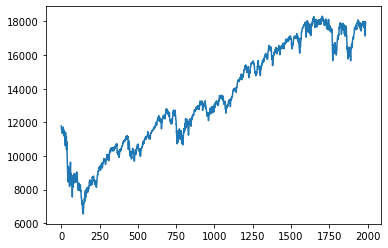

In [65]:
dfClose=df['Close']
dfClose.plot()

In [69]:
def create_dataset(df,attribsSet,attribIndex, prediction_cols,pindex=0,window=10 ):
    x = []
    y = []
    xInput = df[attribsSet[attribIndex]].values
    yInput = df[prediction_cols[pindex]].values
    #print("x",x_in.shape,"y : ", y_in.shape[0])
    for index in df.index:
        if index >= window:
           x.append(xInput[index-window:index].flatten())
           y.append(yInput[index])
    x = np.array(x)
    y = np.array(y)            
    #print(x.shape, y.shape)
    return x,y

In [70]:
def create_dataset_reg(df,attribsSet,attribIndex, prediction_cols,pindex=0,label_col='Label',window=10 ):
    x = []
    y = []
    z = []
    xInput = df[attribsSet[attribIndex]].values
    yInput = df[prediction_cols[pindex]].values
    zInput = df[label_col].values
    #print("x",x_in.shape,"y : ", y_in.shape[0])
    for index in df.index:
        if index >= window:
           x.append(xInput[index-window:index].flatten())
           y.append(yInput[index])
           z.append(zInput[index])
    x = np.array(x)
    y = np.array(y)            
    z = np.array(z)
    #print(x.shape, y.shape)
    return x,y,z

In [71]:
def save_results_to_csv(results, colnames, file_name_suffix ):
    results_df = pd.DataFrame(results,columns=colnames)
    fname='results/'+file_name_suffix+str(time.time())+'.csv'
    results_df.to_csv(fname)

In [72]:
def direction(price_tplusone, price_t):
    if price_tplusone > price_t :
        return 1
    return 0

In [73]:
def accuracy_of_direction(y_predicted,x_test,y_test,attribCols,indexOfPrice=0):
#def accuracy_of_direction(y_predicted, label_test,price_test):                
                collen = len(attribCols)                
                label_predicted = []
                label_test = []
                match_count=0                
                for index in range(0,len(y_predicted)):                     
                     l = len(x_test[index])
                     prev_price = x_test[index][l-collen-1:][indexOfPrice]
                     pred_l=direction(y_predicted[index], prev_price)
                     deriv_l=direction(y_test[index], prev_price)   
                     label_predicted.append(pred_l)  
                     label_test.append(deriv_l)
                     match='N'   
                     if pred_l == deriv_l:
                            match_count=match_count+1
                            match='Y'
                     #print(y_predicted[index],prev_price,y_test[:,0][index],match)   
                    
                ts_acc_pca = accuracy_score(label_test,label_predicted,normalize='false')
                print('Score',ts_acc_pca,match_count,len(label_test))
                return ts_acc_pca

In [74]:
def run_predictions_classifier(df, prediction_cols = [['Label']],
                              attribsSet = [['Close'],['Label'],['Close','Volume'],['Close','Volume','Label'],['Close','Volume','High','Low','Label']],
                              train_percentages=[0.2,0.3,0.5,0.6,0.7],
                              window_sizes = [3,5,10,15,20,30,40,50,55,60,65,70,80,100], 
                              csvPrefix='results_classification'
                              ): 
    
    resultsList=['Attributes','Train Per','Window size','Classifer','Using PCA','Accuracy']    
    modelList = []
    modelList.append(("LogisticReg",LogisticRegression(random_state=42)))
    modelList.append(("RandomForestClassifier",RandomForestClassifier(random_state=42)))
    modelList.append(("SVC",SVC(random_state=42)))
    modelList.append(("DecisionTreeClassifier",DecisionTreeClassifier(random_state=42)))
    modelList.append(("KNeighborsClassifier",KNeighborsClassifier(10)))
    modelList.append(("GaussianNB",GaussianNB()))
    modelList.append(("XGBClassifier",XGBClassifier()))
    modelList.append(("AdaBoostClassifier",AdaBoostClassifier()))    
    ts_acc_best=-2.0
    best=[]    
    
    for attribIndex in range(0,len(attribsSet)):    
        closeVoldf = df[attribsSet[attribIndex]].values                                                
        for train_per in train_percentages:            
            for window in window_sizes:
                
                X,Y = create_dataset(df,attribsSet,attribIndex, prediction_cols,pindex=0,window=window)  
                Y = Y.ravel()
                print(X.shape,Y.shape)
                
                min_max_scaler = MinMaxScaler(feature_range=(0,1))
                X = min_max_scaler.fit_transform(X)                
                                
                x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=(1-train_per), random_state=42)
                for name, classifier in modelList:                                      
                    classifier.fit(x_train,y_train)                    
                    yts_pred = classifier.predict(x_test)
                    ts_acc= accuracy_score(y_test,yts_pred)                        
                    print('Completed ',train_per,window,name,attribsSet[attribIndex]," Score[test]",ts_acc)
                    resultsList.append([attribsSet[attribIndex],train_per,window,name,'N',ts_acc])
                    if(ts_acc_best <= ts_acc) :
                        ts_acc_best = ts_acc
                        best = [train_per,window,name,attribsSet[attribIndex],'No PCA']

                    pca_final = PCA(0.95)
                    df_train_pca = pca_final.fit_transform(x_train)
                    df_test_pca = pca_final.transform(x_test)

                    classifier.fit(df_train_pca,y_train)                    
                    yts_pred_pca = classifier.predict(df_test_pca)
                    
                    ts_acc_pca = accuracy_score(y_test,yts_pred_pca)

                    resultsList.append([attribsSet[attribIndex],train_per,window,name,'Y',ts_acc_pca])
                    print('Completed with PCA with ',pca_final.n_components_,' components',train_per,window,name,attribsSet[attribIndex]," Score[test]",ts_acc_pca)
                    if(ts_acc_best <= ts_acc_pca) :
                        ts_acc_best = ts_acc_pca
                        best = [train_per,window,name,attribsSet[attribIndex],'With PCA']
    print('Best',ts_acc_best,best)          
    save_results_to_csv(resultsList[6:],['Attributes','Train Per','Window size','Classifer','Using PCA','Accuracy'],csvPrefix)

In [75]:
run_predictions_classifier(df, 
                          csvPrefix='results_classification_tplus1_')

(1983, 5) (1983,)
Completed  0.1 5 LogisticReg ['Close']  Score[test] 0.5310924369747899
Completed with PCA with  1  components 0.1 5 LogisticReg ['Close']  Score[test] 0.5310924369747899
Completed  0.1 5 RandomForestClassifier ['Close']  Score[test] 0.5025210084033613
Completed with PCA with  1  components 0.1 5 RandomForestClassifier ['Close']  Score[test] 0.5030812324929972
Completed  0.1 5 SVC ['Close']  Score[test] 0.5310924369747899
Completed with PCA with  1  components 0.1 5 SVC ['Close']  Score[test] 0.5310924369747899
Completed  0.1 5 DecisionTreeClassifier ['Close']  Score[test] 0.4946778711484594
Completed with PCA with  1  components 0.1 5 DecisionTreeClassifier ['Close']  Score[test] 0.5030812324929972
Completed  0.1 5 KNeighborsClassifier ['Close']  Score[test] 0.5142857142857142
Completed with PCA with  1  components 0.1 5 KNeighborsClassifier ['Close']  Score[test] 0.5154061624649859
Completed  0.1 5 GaussianNB ['Close']  Score[test] 0.4969187675070028
Completed with P

Completed  0.1 40 XGBClassifier ['Close']  Score[test] 0.4977194982896237
Completed with PCA with  1  components 0.1 40 XGBClassifier ['Close']  Score[test] 0.5091220068415051
Completed  0.1 40 AdaBoostClassifier ['Close']  Score[test] 0.4863169897377423
Completed with PCA with  1  components 0.1 40 AdaBoostClassifier ['Close']  Score[test] 0.5011402508551881
(1938, 50) (1938,)
Completed  0.1 50 LogisticReg ['Close']  Score[test] 0.47277936962750716
Completed with PCA with  1  components 0.1 50 LogisticReg ['Close']  Score[test] 0.4802292263610315
Completed  0.1 50 RandomForestClassifier ['Close']  Score[test] 0.5163323782234956
Completed with PCA with  1  components 0.1 50 RandomForestClassifier ['Close']  Score[test] 0.504297994269341
Completed  0.1 50 SVC ['Close']  Score[test] 0.4911174785100286
Completed with PCA with  1  components 0.1 50 SVC ['Close']  Score[test] 0.4899713467048711
Completed  0.1 50 DecisionTreeClassifier ['Close']  Score[test] 0.5088825214899714
Completed with

Completed with PCA with  1  components 0.1 80 KNeighborsClassifier ['Close']  Score[test] 0.5034924330616997
Completed  0.1 80 GaussianNB ['Close']  Score[test] 0.4988358556461001
Completed with PCA with  1  components 0.1 80 GaussianNB ['Close']  Score[test] 0.540162980209546
Completed  0.1 80 XGBClassifier ['Close']  Score[test] 0.509895227008149
Completed with PCA with  1  components 0.1 80 XGBClassifier ['Close']  Score[test] 0.5075669383003493
Completed  0.1 80 AdaBoostClassifier ['Close']  Score[test] 0.509895227008149
Completed with PCA with  1  components 0.1 80 AdaBoostClassifier ['Close']  Score[test] 0.49941792782305006
(1888, 100) (1888,)
Completed  0.1 100 LogisticReg ['Close']  Score[test] 0.47823529411764704
Completed with PCA with  1  components 0.1 100 LogisticReg ['Close']  Score[test] 0.49
Completed  0.1 100 RandomForestClassifier ['Close']  Score[test] 0.49058823529411766
Completed with PCA with  1  components 0.1 100 RandomForestClassifier ['Close']  Score[test] 0.

Completed  0.2 30 DecisionTreeClassifier ['Close']  Score[test] 0.4958519463943842
Completed with PCA with  1  components 0.2 30 DecisionTreeClassifier ['Close']  Score[test] 0.5047862156987875
Completed  0.2 30 KNeighborsClassifier ['Close']  Score[test] 0.5201021059349075
Completed with PCA with  1  components 0.2 30 KNeighborsClassifier ['Close']  Score[test] 0.5060625398851308
Completed  0.2 30 GaussianNB ['Close']  Score[test] 0.48755583918315254
Completed with PCA with  1  components 0.2 30 GaussianNB ['Close']  Score[test] 0.5124441608168475
Completed  0.2 30 XGBClassifier ['Close']  Score[test] 0.4907466496490108
Completed with PCA with  1  components 0.2 30 XGBClassifier ['Close']  Score[test] 0.5149968091895342
Completed  0.2 30 AdaBoostClassifier ['Close']  Score[test] 0.5124441608168475
Completed with PCA with  1  components 0.2 30 AdaBoostClassifier ['Close']  Score[test] 0.5022335673261008
(1948, 40) (1948,)
Completed  0.2 40 LogisticReg ['Close']  Score[test] 0.526619627

Completed  0.2 70 RandomForestClassifier ['Close']  Score[test] 0.49120521172638437
Completed with PCA with  1  components 0.2 70 RandomForestClassifier ['Close']  Score[test] 0.5061889250814332
Completed  0.2 70 SVC ['Close']  Score[test] 0.49576547231270357
Completed with PCA with  1  components 0.2 70 SVC ['Close']  Score[test] 0.495114006514658
Completed  0.2 70 DecisionTreeClassifier ['Close']  Score[test] 0.504885993485342
Completed with PCA with  1  components 0.2 70 DecisionTreeClassifier ['Close']  Score[test] 0.5061889250814332
Completed  0.2 70 KNeighborsClassifier ['Close']  Score[test] 0.48925081433224754
Completed with PCA with  1  components 0.2 70 KNeighborsClassifier ['Close']  Score[test] 0.48469055374592834
Completed  0.2 70 GaussianNB ['Close']  Score[test] 0.48013029315960915
Completed with PCA with  1  components 0.2 70 GaussianNB ['Close']  Score[test] 0.5127035830618892
Completed  0.2 70 XGBClassifier ['Close']  Score[test] 0.495114006514658
Completed with PCA w

Completed with PCA with  1  components 0.3 15 XGBClassifier ['Close']  Score[test] 0.5101302460202605
Completed  0.3 15 AdaBoostClassifier ['Close']  Score[test] 0.5021707670043415
Completed with PCA with  1  components 0.3 15 AdaBoostClassifier ['Close']  Score[test] 0.5144717800289436
(1968, 20) (1968,)
Completed  0.3 20 LogisticReg ['Close']  Score[test] 0.52322206095791
Completed with PCA with  1  components 0.3 20 LogisticReg ['Close']  Score[test] 0.52322206095791
Completed  0.3 20 RandomForestClassifier ['Close']  Score[test] 0.5123367198838897
Completed with PCA with  1  components 0.3 20 RandomForestClassifier ['Close']  Score[test] 0.49782293178519593
Completed  0.3 20 SVC ['Close']  Score[test] 0.52322206095791
Completed with PCA with  1  components 0.3 20 SVC ['Close']  Score[test] 0.52322206095791
Completed  0.3 20 DecisionTreeClassifier ['Close']  Score[test] 0.49782293178519593
Completed with PCA with  1  components 0.3 20 DecisionTreeClassifier ['Close']  Score[test] 0.

Completed with PCA with  1  components 0.3 60 KNeighborsClassifier ['Close']  Score[test] 0.5140740740740741
Completed  0.3 60 GaussianNB ['Close']  Score[test] 0.5022222222222222
Completed with PCA with  1  components 0.3 60 GaussianNB ['Close']  Score[test] 0.5385185185185185
Completed  0.3 60 XGBClassifier ['Close']  Score[test] 0.5037037037037037
Completed with PCA with  1  components 0.3 60 XGBClassifier ['Close']  Score[test] 0.4955555555555556
Completed  0.3 60 AdaBoostClassifier ['Close']  Score[test] 0.5162962962962963
Completed with PCA with  1  components 0.3 60 AdaBoostClassifier ['Close']  Score[test] 0.5385185185185185
(1923, 65) (1923,)
Completed  0.3 65 LogisticReg ['Close']  Score[test] 0.5412026726057907
Completed with PCA with  1  components 0.3 65 LogisticReg ['Close']  Score[test] 0.5493689680772086
Completed  0.3 65 RandomForestClassifier ['Close']  Score[test] 0.5167037861915368
Completed with PCA with  1  components 0.3 65 RandomForestClassifier ['Close']  Score

Completed with PCA with  1  components 0.5 10 RandomForestClassifier ['Close']  Score[test] 0.474216380182002
Completed  0.5 10 SVC ['Close']  Score[test] 0.5288169868554095
Completed with PCA with  1  components 0.5 10 SVC ['Close']  Score[test] 0.5278058645096056
Completed  0.5 10 DecisionTreeClassifier ['Close']  Score[test] 0.5035389282103134
Completed with PCA with  1  components 0.5 10 DecisionTreeClassifier ['Close']  Score[test] 0.474216380182002
Completed  0.5 10 KNeighborsClassifier ['Close']  Score[test] 0.49443882709807885
Completed with PCA with  1  components 0.5 10 KNeighborsClassifier ['Close']  Score[test] 0.48028311425682507
Completed  0.5 10 GaussianNB ['Close']  Score[test] 0.4833164812942366
Completed with PCA with  1  components 0.5 10 GaussianNB ['Close']  Score[test] 0.5156723963599595
Completed  0.5 10 XGBClassifier ['Close']  Score[test] 0.49848331648129424
Completed with PCA with  1  components 0.5 10 XGBClassifier ['Close']  Score[test] 0.4863498483316481
Co

Completed  0.5 50 AdaBoostClassifier ['Close']  Score[test] 0.500515995872033
Completed with PCA with  1  components 0.5 50 AdaBoostClassifier ['Close']  Score[test] 0.48606811145510836
(1933, 55) (1933,)
Completed  0.5 55 LogisticReg ['Close']  Score[test] 0.5253360910031024
Completed with PCA with  1  components 0.5 55 LogisticReg ['Close']  Score[test] 0.5253360910031024
Completed  0.5 55 RandomForestClassifier ['Close']  Score[test] 0.5253360910031024
Completed with PCA with  1  components 0.5 55 RandomForestClassifier ['Close']  Score[test] 0.48190279214064113
Completed  0.5 55 SVC ['Close']  Score[test] 0.5253360910031024
Completed with PCA with  1  components 0.5 55 SVC ['Close']  Score[test] 0.5253360910031024
Completed  0.5 55 DecisionTreeClassifier ['Close']  Score[test] 0.4922440537745605
Completed with PCA with  1  components 0.5 55 DecisionTreeClassifier ['Close']  Score[test] 0.48190279214064113
Completed  0.5 55 KNeighborsClassifier ['Close']  Score[test] 0.4922440537745

Completed  0.5 100 XGBClassifier ['Close']  Score[test] 0.510593220338983
Completed with PCA with  1  components 0.5 100 XGBClassifier ['Close']  Score[test] 0.5370762711864406
Completed  0.5 100 AdaBoostClassifier ['Close']  Score[test] 0.4989406779661017
Completed with PCA with  1  components 0.5 100 AdaBoostClassifier ['Close']  Score[test] 0.5423728813559322
(1983, 5) (1983,)
Completed  0.6 5 LogisticReg ['Close']  Score[test] 0.5340050377833753
Completed with PCA with  1  components 0.6 5 LogisticReg ['Close']  Score[test] 0.5340050377833753
Completed  0.6 5 RandomForestClassifier ['Close']  Score[test] 0.5100755667506297
Completed with PCA with  1  components 0.6 5 RandomForestClassifier ['Close']  Score[test] 0.5037783375314862
Completed  0.6 5 SVC ['Close']  Score[test] 0.5264483627204031
Completed with PCA with  1  components 0.6 5 SVC ['Close']  Score[test] 0.5251889168765743
Completed  0.6 5 DecisionTreeClassifier ['Close']  Score[test] 0.5138539042821159
Completed with PCA 

Completed  0.6 40 XGBClassifier ['Close']  Score[test] 0.5205128205128206
Completed with PCA with  1  components 0.6 40 XGBClassifier ['Close']  Score[test] 0.5333333333333333
Completed  0.6 40 AdaBoostClassifier ['Close']  Score[test] 0.5269230769230769
Completed with PCA with  1  components 0.6 40 AdaBoostClassifier ['Close']  Score[test] 0.4846153846153846
(1938, 50) (1938,)
Completed  0.6 50 LogisticReg ['Close']  Score[test] 0.5412371134020618
Completed with PCA with  1  components 0.6 50 LogisticReg ['Close']  Score[test] 0.5425257731958762
Completed  0.6 50 RandomForestClassifier ['Close']  Score[test] 0.5154639175257731
Completed with PCA with  1  components 0.6 50 RandomForestClassifier ['Close']  Score[test] 0.5051546391752577
Completed  0.6 50 SVC ['Close']  Score[test] 0.5360824742268041
Completed with PCA with  1  components 0.6 50 SVC ['Close']  Score[test] 0.538659793814433
Completed  0.6 50 DecisionTreeClassifier ['Close']  Score[test] 0.5141752577319587
Completed with 

Completed with PCA with  1  components 0.6 80 KNeighborsClassifier ['Close']  Score[test] 0.4973821989528796
Completed  0.6 80 GaussianNB ['Close']  Score[test] 0.5143979057591623
Completed with PCA with  1  components 0.6 80 GaussianNB ['Close']  Score[test] 0.524869109947644
Completed  0.6 80 XGBClassifier ['Close']  Score[test] 0.5026178010471204
Completed with PCA with  1  components 0.6 80 XGBClassifier ['Close']  Score[test] 0.5117801047120419
Completed  0.6 80 AdaBoostClassifier ['Close']  Score[test] 0.5143979057591623
Completed with PCA with  1  components 0.6 80 AdaBoostClassifier ['Close']  Score[test] 0.5078534031413613
(1888, 100) (1888,)
Completed  0.6 100 LogisticReg ['Close']  Score[test] 0.5462962962962963
Completed with PCA with  1  components 0.6 100 LogisticReg ['Close']  Score[test] 0.5582010582010583
Completed  0.6 100 RandomForestClassifier ['Close']  Score[test] 0.4933862433862434
Completed with PCA with  1  components 0.6 100 RandomForestClassifier ['Close']  S

Completed with PCA with  1  components 0.7 30 SVC ['Close']  Score[test] 0.5476190476190477
Completed  0.7 30 DecisionTreeClassifier ['Close']  Score[test] 0.5221088435374149
Completed with PCA with  1  components 0.7 30 DecisionTreeClassifier ['Close']  Score[test] 0.47959183673469385
Completed  0.7 30 KNeighborsClassifier ['Close']  Score[test] 0.49829931972789115
Completed with PCA with  1  components 0.7 30 KNeighborsClassifier ['Close']  Score[test] 0.4744897959183674
Completed  0.7 30 GaussianNB ['Close']  Score[test] 0.5068027210884354
Completed with PCA with  1  components 0.7 30 GaussianNB ['Close']  Score[test] 0.5476190476190477
Completed  0.7 30 XGBClassifier ['Close']  Score[test] 0.49829931972789115
Completed with PCA with  1  components 0.7 30 XGBClassifier ['Close']  Score[test] 0.5034013605442177
Completed  0.7 30 AdaBoostClassifier ['Close']  Score[test] 0.5085034013605442
Completed with PCA with  1  components 0.7 30 AdaBoostClassifier ['Close']  Score[test] 0.518707

Completed  0.7 70 RandomForestClassifier ['Close']  Score[test] 0.5225694444444444
Completed with PCA with  1  components 0.7 70 RandomForestClassifier ['Close']  Score[test] 0.5069444444444444
Completed  0.7 70 SVC ['Close']  Score[test] 0.5347222222222222
Completed with PCA with  1  components 0.7 70 SVC ['Close']  Score[test] 0.5225694444444444
Completed  0.7 70 DecisionTreeClassifier ['Close']  Score[test] 0.4878472222222222
Completed with PCA with  1  components 0.7 70 DecisionTreeClassifier ['Close']  Score[test] 0.5069444444444444
Completed  0.7 70 KNeighborsClassifier ['Close']  Score[test] 0.5190972222222222
Completed with PCA with  1  components 0.7 70 KNeighborsClassifier ['Close']  Score[test] 0.53125
Completed  0.7 70 GaussianNB ['Close']  Score[test] 0.5
Completed with PCA with  1  components 0.7 70 GaussianNB ['Close']  Score[test] 0.5399305555555556
Completed  0.7 70 XGBClassifier ['Close']  Score[test] 0.4878472222222222
Completed with PCA with  1  components 0.7 70 XG

Completed  0.8 15 AdaBoostClassifier ['Close']  Score[test] 0.5164556962025316
Completed with PCA with  1  components 0.8 15 AdaBoostClassifier ['Close']  Score[test] 0.5316455696202531
(1968, 20) (1968,)
Completed  0.8 20 LogisticReg ['Close']  Score[test] 0.5329949238578681
Completed with PCA with  1  components 0.8 20 LogisticReg ['Close']  Score[test] 0.5329949238578681
Completed  0.8 20 RandomForestClassifier ['Close']  Score[test] 0.4873096446700508
Completed with PCA with  1  components 0.8 20 RandomForestClassifier ['Close']  Score[test] 0.5025380710659898
Completed  0.8 20 SVC ['Close']  Score[test] 0.5329949238578681
Completed with PCA with  1  components 0.8 20 SVC ['Close']  Score[test] 0.5329949238578681
Completed  0.8 20 DecisionTreeClassifier ['Close']  Score[test] 0.43908629441624364
Completed with PCA with  1  components 0.8 20 DecisionTreeClassifier ['Close']  Score[test] 0.5025380710659898
Completed  0.8 20 KNeighborsClassifier ['Close']  Score[test] 0.47208121827411

Completed  0.8 60 XGBClassifier ['Close']  Score[test] 0.5051813471502591
Completed with PCA with  1  components 0.8 60 XGBClassifier ['Close']  Score[test] 0.49222797927461137
Completed  0.8 60 AdaBoostClassifier ['Close']  Score[test] 0.5207253886010362
Completed with PCA with  1  components 0.8 60 AdaBoostClassifier ['Close']  Score[test] 0.5259067357512953
(1923, 65) (1923,)
Completed  0.8 65 LogisticReg ['Close']  Score[test] 0.5246753246753246
Completed with PCA with  1  components 0.8 65 LogisticReg ['Close']  Score[test] 0.5246753246753246
Completed  0.8 65 RandomForestClassifier ['Close']  Score[test] 0.4623376623376623
Completed with PCA with  1  components 0.8 65 RandomForestClassifier ['Close']  Score[test] 0.4597402597402597
Completed  0.8 65 SVC ['Close']  Score[test] 0.5246753246753246
Completed with PCA with  1  components 0.8 65 SVC ['Close']  Score[test] 0.5246753246753246
Completed  0.8 65 DecisionTreeClassifier ['Close']  Score[test] 0.4987012987012987
Completed wit

Completed  0.1 10 GaussianNB ['Label']  Score[test] 0.4783829309376755
Completed with PCA with  10  components 0.1 10 GaussianNB ['Label']  Score[test] 0.48006737787759685
Completed  0.1 10 XGBClassifier ['Label']  Score[test] 0.4811903425042111
Completed with PCA with  10  components 0.1 10 XGBClassifier ['Label']  Score[test] 0.48175182481751827
Completed  0.1 10 AdaBoostClassifier ['Label']  Score[test] 0.4783829309376755
Completed with PCA with  10  components 0.1 10 AdaBoostClassifier ['Label']  Score[test] 0.4918585064570466
(1973, 15) (1973,)
Completed  0.1 15 LogisticReg ['Label']  Score[test] 0.518581081081081
Completed with PCA with  14  components 0.1 15 LogisticReg ['Label']  Score[test] 0.5292792792792793
Completed  0.1 15 RandomForestClassifier ['Label']  Score[test] 0.5180180180180181
Completed with PCA with  14  components 0.1 15 RandomForestClassifier ['Label']  Score[test] 0.5259009009009009
Completed  0.1 15 SVC ['Label']  Score[test] 0.5202702702702703
Completed wit

Completed with PCA with  47  components 0.1 55 KNeighborsClassifier ['Label']  Score[test] 0.5132183908045977
Completed  0.1 55 GaussianNB ['Label']  Score[test] 0.5172413793103449
Completed with PCA with  47  components 0.1 55 GaussianNB ['Label']  Score[test] 0.5040229885057471
Completed  0.1 55 XGBClassifier ['Label']  Score[test] 0.506896551724138
Completed with PCA with  47  components 0.1 55 XGBClassifier ['Label']  Score[test] 0.5057471264367817
Completed  0.1 55 AdaBoostClassifier ['Label']  Score[test] 0.5201149425287356
Completed with PCA with  47  components 0.1 55 AdaBoostClassifier ['Label']  Score[test] 0.5074712643678161
(1928, 60) (1928,)
Completed  0.1 60 LogisticReg ['Label']  Score[test] 0.5213133640552995
Completed with PCA with  51  components 0.1 60 LogisticReg ['Label']  Score[test] 0.5149769585253456
Completed  0.1 60 RandomForestClassifier ['Label']  Score[test] 0.5328341013824884
Completed with PCA with  51  components 0.1 60 RandomForestClassifier ['Label']  

Completed with PCA with  5  components 0.2 5 RandomForestClassifier ['Label']  Score[test] 0.5091367359798362
Completed  0.2 5 SVC ['Label']  Score[test] 0.5148078134845621
Completed with PCA with  5  components 0.2 5 SVC ['Label']  Score[test] 0.5148078134845621
Completed  0.2 5 DecisionTreeClassifier ['Label']  Score[test] 0.504725897920605
Completed with PCA with  5  components 0.2 5 DecisionTreeClassifier ['Label']  Score[test] 0.504725897920605
Completed  0.2 5 KNeighborsClassifier ['Label']  Score[test] 0.5059861373660995
Completed with PCA with  5  components 0.2 5 KNeighborsClassifier ['Label']  Score[test] 0.49464398235664775
Completed  0.2 5 GaussianNB ['Label']  Score[test] 0.520478890989288
Completed with PCA with  5  components 0.2 5 GaussianNB ['Label']  Score[test] 0.5211090107120353
Completed  0.2 5 XGBClassifier ['Label']  Score[test] 0.5091367359798362
Completed with PCA with  5  components 0.2 5 XGBClassifier ['Label']  Score[test] 0.5053560176433523
Completed  0.2 5

Completed with PCA with  37  components 0.2 40 XGBClassifier ['Label']  Score[test] 0.5163566388710712
Completed  0.2 40 AdaBoostClassifier ['Label']  Score[test] 0.5093008338678641
Completed with PCA with  37  components 0.2 40 AdaBoostClassifier ['Label']  Score[test] 0.5035279025016036
(1938, 50) (1938,)
Completed  0.2 50 LogisticReg ['Label']  Score[test] 0.5203094777562862
Completed with PCA with  45  components 0.2 50 LogisticReg ['Label']  Score[test] 0.5177304964539007
Completed  0.2 50 RandomForestClassifier ['Label']  Score[test] 0.5093488072211476
Completed with PCA with  45  components 0.2 50 RandomForestClassifier ['Label']  Score[test] 0.5183752417794971
Completed  0.2 50 SVC ['Label']  Score[test] 0.5299806576402321
Completed with PCA with  45  components 0.2 50 SVC ['Label']  Score[test] 0.521598968407479
Completed  0.2 50 DecisionTreeClassifier ['Label']  Score[test] 0.5074145712443585
Completed with PCA with  45  components 0.2 50 DecisionTreeClassifier ['Label']  Sco

Completed with PCA with  70  components 0.2 80 KNeighborsClassifier ['Label']  Score[test] 0.49443352979698757
Completed  0.2 80 GaussianNB ['Label']  Score[test] 0.5009823182711198
Completed with PCA with  70  components 0.2 80 GaussianNB ['Label']  Score[test] 0.4885396201702685
Completed  0.2 80 XGBClassifier ['Label']  Score[test] 0.5153896529142109
Completed with PCA with  70  components 0.2 80 XGBClassifier ['Label']  Score[test] 0.5147347740667977
Completed  0.2 80 AdaBoostClassifier ['Label']  Score[test] 0.4977079240340537
Completed with PCA with  70  components 0.2 80 AdaBoostClassifier ['Label']  Score[test] 0.4885396201702685
(1888, 100) (1888,)
Completed  0.2 100 LogisticReg ['Label']  Score[test] 0.4937127729980146
Completed with PCA with  86  components 0.2 100 LogisticReg ['Label']  Score[test] 0.4956982131039047
Completed  0.2 100 RandomForestClassifier ['Label']  Score[test] 0.5036399735274653
Completed with PCA with  86  components 0.2 100 RandomForestClassifier ['La

Completed with PCA with  28  components 0.3 30 RandomForestClassifier ['Label']  Score[test] 0.4974471188913202
Completed  0.3 30 SVC ['Label']  Score[test] 0.5171407731582787
Completed with PCA with  28  components 0.3 30 SVC ['Label']  Score[test] 0.5113056163384391
Completed  0.3 30 DecisionTreeClassifier ['Label']  Score[test] 0.5083880379285193
Completed with PCA with  28  components 0.3 30 DecisionTreeClassifier ['Label']  Score[test] 0.5083880379285193
Completed  0.3 30 KNeighborsClassifier ['Label']  Score[test] 0.50036469730124
Completed with PCA with  28  components 0.3 30 KNeighborsClassifier ['Label']  Score[test] 0.5054704595185996
Completed  0.3 30 GaussianNB ['Label']  Score[test] 0.5222465353756383
Completed with PCA with  28  components 0.3 30 GaussianNB ['Label']  Score[test] 0.5237053245805982
Completed  0.3 30 XGBClassifier ['Label']  Score[test] 0.5171407731582787
Completed with PCA with  28  components 0.3 30 XGBClassifier ['Label']  Score[test] 0.5047410649161196

Completed with PCA with  59  components 0.3 65 XGBClassifier ['Label']  Score[test] 0.4922048997772829
Completed  0.3 65 AdaBoostClassifier ['Label']  Score[test] 0.5129918337045286
Completed with PCA with  59  components 0.3 65 AdaBoostClassifier ['Label']  Score[test] 0.5085374907201188
(1918, 70) (1918,)
Completed  0.3 70 LogisticReg ['Label']  Score[test] 0.5368577810871183
Completed with PCA with  64  components 0.3 70 LogisticReg ['Label']  Score[test] 0.530156366344006
Completed  0.3 70 RandomForestClassifier ['Label']  Score[test] 0.5256887565152644
Completed with PCA with  64  components 0.3 70 RandomForestClassifier ['Label']  Score[test] 0.5145197319434103
Completed  0.3 70 SVC ['Label']  Score[test] 0.5361131794489948
Completed with PCA with  64  components 0.3 70 SVC ['Label']  Score[test] 0.5323901712583767
Completed  0.3 70 DecisionTreeClassifier ['Label']  Score[test] 0.49441548771407295
Completed with PCA with  64  components 0.3 70 DecisionTreeClassifier ['Label']  Sc

Completed  0.5 15 XGBClassifier ['Label']  Score[test] 0.49949341438703143
Completed with PCA with  15  components 0.5 15 XGBClassifier ['Label']  Score[test] 0.5055724417426545
Completed  0.5 15 AdaBoostClassifier ['Label']  Score[test] 0.5116514690982776
Completed with PCA with  15  components 0.5 15 AdaBoostClassifier ['Label']  Score[test] 0.5055724417426545
(1968, 20) (1968,)
Completed  0.5 20 LogisticReg ['Label']  Score[test] 0.5172764227642277
Completed with PCA with  19  components 0.5 20 LogisticReg ['Label']  Score[test] 0.516260162601626
Completed  0.5 20 RandomForestClassifier ['Label']  Score[test] 0.5111788617886179
Completed with PCA with  19  components 0.5 20 RandomForestClassifier ['Label']  Score[test] 0.5315040650406504
Completed  0.5 20 SVC ['Label']  Score[test] 0.5040650406504065
Completed with PCA with  19  components 0.5 20 SVC ['Label']  Score[test] 0.5091463414634146
Completed  0.5 20 DecisionTreeClassifier ['Label']  Score[test] 0.4949186991869919
Completed

Completed  0.5 60 XGBClassifier ['Label']  Score[test] 0.5321576763485477
Completed with PCA with  56  components 0.5 60 XGBClassifier ['Label']  Score[test] 0.5124481327800829
Completed  0.5 60 AdaBoostClassifier ['Label']  Score[test] 0.5124481327800829
Completed with PCA with  56  components 0.5 60 AdaBoostClassifier ['Label']  Score[test] 0.5134854771784232
(1923, 65) (1923,)
Completed  0.5 65 LogisticReg ['Label']  Score[test] 0.5041580041580042
Completed with PCA with  60  components 0.5 65 LogisticReg ['Label']  Score[test] 0.5031185031185031
Completed  0.5 65 RandomForestClassifier ['Label']  Score[test] 0.5187110187110187
Completed with PCA with  60  components 0.5 65 RandomForestClassifier ['Label']  Score[test] 0.5135135135135135
Completed  0.5 65 SVC ['Label']  Score[test] 0.524948024948025
Completed with PCA with  60  components 0.5 65 SVC ['Label']  Score[test] 0.524948024948025
Completed  0.5 65 DecisionTreeClassifier ['Label']  Score[test] 0.4916839916839917
Completed w

Completed  0.6 10 XGBClassifier ['Label']  Score[test] 0.4621212121212121
Completed with PCA with  10  components 0.6 10 XGBClassifier ['Label']  Score[test] 0.48358585858585856
Completed  0.6 10 AdaBoostClassifier ['Label']  Score[test] 0.5252525252525253
Completed with PCA with  10  components 0.6 10 AdaBoostClassifier ['Label']  Score[test] 0.5252525252525253
(1973, 15) (1973,)
Completed  0.6 15 LogisticReg ['Label']  Score[test] 0.520253164556962
Completed with PCA with  15  components 0.6 15 LogisticReg ['Label']  Score[test] 0.520253164556962
Completed  0.6 15 RandomForestClassifier ['Label']  Score[test] 0.4936708860759494
Completed with PCA with  15  components 0.6 15 RandomForestClassifier ['Label']  Score[test] 0.5164556962025316
Completed  0.6 15 SVC ['Label']  Score[test] 0.4759493670886076
Completed with PCA with  15  components 0.6 15 SVC ['Label']  Score[test] 0.4759493670886076
Completed  0.6 15 DecisionTreeClassifier ['Label']  Score[test] 0.5050632911392405
Completed 

Completed  0.6 55 XGBClassifier ['Label']  Score[test] 0.5116279069767442
Completed with PCA with  51  components 0.6 55 XGBClassifier ['Label']  Score[test] 0.5297157622739018
Completed  0.6 55 AdaBoostClassifier ['Label']  Score[test] 0.5490956072351422
Completed with PCA with  51  components 0.6 55 AdaBoostClassifier ['Label']  Score[test] 0.537467700258398
(1928, 60) (1928,)
Completed  0.6 60 LogisticReg ['Label']  Score[test] 0.5129533678756477
Completed with PCA with  56  components 0.6 60 LogisticReg ['Label']  Score[test] 0.5103626943005182
Completed  0.6 60 RandomForestClassifier ['Label']  Score[test] 0.5310880829015544
Completed with PCA with  56  components 0.6 60 RandomForestClassifier ['Label']  Score[test] 0.5272020725388601
Completed  0.6 60 SVC ['Label']  Score[test] 0.5155440414507773
Completed with PCA with  56  components 0.6 60 SVC ['Label']  Score[test] 0.5038860103626943
Completed  0.6 60 DecisionTreeClassifier ['Label']  Score[test] 0.4883419689119171
Completed 

Completed with PCA with  5  components 0.7 5 XGBClassifier ['Label']  Score[test] 0.507563025210084
Completed  0.7 5 AdaBoostClassifier ['Label']  Score[test] 0.5058823529411764
Completed with PCA with  5  components 0.7 5 AdaBoostClassifier ['Label']  Score[test] 0.507563025210084
(1978, 10) (1978,)
Completed  0.7 10 LogisticReg ['Label']  Score[test] 0.5185185185185185
Completed with PCA with  10  components 0.7 10 LogisticReg ['Label']  Score[test] 0.5185185185185185
Completed  0.7 10 RandomForestClassifier ['Label']  Score[test] 0.4882154882154882
Completed with PCA with  10  components 0.7 10 RandomForestClassifier ['Label']  Score[test] 0.48484848484848486
Completed  0.7 10 SVC ['Label']  Score[test] 0.5016835016835017
Completed with PCA with  10  components 0.7 10 SVC ['Label']  Score[test] 0.5016835016835017
Completed  0.7 10 DecisionTreeClassifier ['Label']  Score[test] 0.4764309764309764
Completed with PCA with  10  components 0.7 10 DecisionTreeClassifier ['Label']  Score[te

Completed  0.7 50 XGBClassifier ['Label']  Score[test] 0.5120274914089347
Completed with PCA with  47  components 0.7 50 XGBClassifier ['Label']  Score[test] 0.5171821305841925
Completed  0.7 50 AdaBoostClassifier ['Label']  Score[test] 0.5171821305841925
Completed with PCA with  47  components 0.7 50 AdaBoostClassifier ['Label']  Score[test] 0.5051546391752577
(1933, 55) (1933,)
Completed  0.7 55 LogisticReg ['Label']  Score[test] 0.5206896551724138
Completed with PCA with  51  components 0.7 55 LogisticReg ['Label']  Score[test] 0.5379310344827586
Completed  0.7 55 RandomForestClassifier ['Label']  Score[test] 0.5086206896551724
Completed with PCA with  51  components 0.7 55 RandomForestClassifier ['Label']  Score[test] 0.5344827586206896
Completed  0.7 55 SVC ['Label']  Score[test] 0.5448275862068965
Completed with PCA with  51  components 0.7 55 SVC ['Label']  Score[test] 0.5517241379310345
Completed  0.7 55 DecisionTreeClassifier ['Label']  Score[test] 0.4672413793103448
Completed

Completed  0.7 100 KNeighborsClassifier ['Label']  Score[test] 0.4444444444444444
Completed with PCA with  92  components 0.7 100 KNeighborsClassifier ['Label']  Score[test] 0.455026455026455
Completed  0.7 100 GaussianNB ['Label']  Score[test] 0.5220458553791887
Completed with PCA with  92  components 0.7 100 GaussianNB ['Label']  Score[test] 0.5149911816578483
Completed  0.7 100 XGBClassifier ['Label']  Score[test] 0.5008818342151675
Completed with PCA with  92  components 0.7 100 XGBClassifier ['Label']  Score[test] 0.527336860670194
Completed  0.7 100 AdaBoostClassifier ['Label']  Score[test] 0.5220458553791887
Completed with PCA with  92  components 0.7 100 AdaBoostClassifier ['Label']  Score[test] 0.5008818342151675
(1983, 5) (1983,)
Completed  0.8 5 LogisticReg ['Label']  Score[test] 0.5314861460957179
Completed with PCA with  5  components 0.8 5 LogisticReg ['Label']  Score[test] 0.5314861460957179
Completed  0.8 5 RandomForestClassifier ['Label']  Score[test] 0.541561712846347

Completed  0.8 40 RandomForestClassifier ['Label']  Score[test] 0.5307692307692308
Completed with PCA with  38  components 0.8 40 RandomForestClassifier ['Label']  Score[test] 0.5256410256410257
Completed  0.8 40 SVC ['Label']  Score[test] 0.49743589743589745
Completed with PCA with  38  components 0.8 40 SVC ['Label']  Score[test] 0.5
Completed  0.8 40 DecisionTreeClassifier ['Label']  Score[test] 0.541025641025641
Completed with PCA with  38  components 0.8 40 DecisionTreeClassifier ['Label']  Score[test] 0.48205128205128206
Completed  0.8 40 KNeighborsClassifier ['Label']  Score[test] 0.5461538461538461
Completed with PCA with  38  components 0.8 40 KNeighborsClassifier ['Label']  Score[test] 0.5615384615384615
Completed  0.8 40 GaussianNB ['Label']  Score[test] 0.5076923076923077
Completed with PCA with  38  components 0.8 40 GaussianNB ['Label']  Score[test] 0.5076923076923077
Completed  0.8 40 XGBClassifier ['Label']  Score[test] 0.4897435897435897
Completed with PCA with  38  co

Completed with PCA with  65  components 0.8 70 XGBClassifier ['Label']  Score[test] 0.46875
Completed  0.8 70 AdaBoostClassifier ['Label']  Score[test] 0.5026041666666666
Completed with PCA with  65  components 0.8 70 AdaBoostClassifier ['Label']  Score[test] 0.4921875
(1908, 80) (1908,)
Completed  0.8 80 LogisticReg ['Label']  Score[test] 0.5314136125654451
Completed with PCA with  74  components 0.8 80 LogisticReg ['Label']  Score[test] 0.5052356020942408
Completed  0.8 80 RandomForestClassifier ['Label']  Score[test] 0.5732984293193717
Completed with PCA with  74  components 0.8 80 RandomForestClassifier ['Label']  Score[test] 0.5130890052356021
Completed  0.8 80 SVC ['Label']  Score[test] 0.5157068062827225
Completed with PCA with  74  components 0.8 80 SVC ['Label']  Score[test] 0.5104712041884817
Completed  0.8 80 DecisionTreeClassifier ['Label']  Score[test] 0.5
Completed with PCA with  74  components 0.8 80 DecisionTreeClassifier ['Label']  Score[test] 0.4816753926701571
Comple

Completed  0.1 20 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5124153498871332
Completed with PCA with  6  components 0.1 20 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5163656884875847
Completed  0.1 20 SVC ['Close', 'Volume']  Score[test] 0.510158013544018
Completed with PCA with  6  components 0.1 20 SVC ['Close', 'Volume']  Score[test] 0.5146726862302483
Completed  0.1 20 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5011286681715575
Completed with PCA with  6  components 0.1 20 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5033860045146726
Completed  0.1 20 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.5174943566591422
Completed with PCA with  6  components 0.1 20 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.5062076749435666
Completed  0.1 20 GaussianNB ['Close', 'Volume']  Score[test] 0.5084650112866818
Completed with PCA with  6  components 0.1 20 GaussianNB ['Close', 'Volume']  Score[test] 0.53386004514672

Completed with PCA with  13  components 0.1 60 SVC ['Close', 'Volume']  Score[test] 0.5305299539170507
Completed  0.1 60 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5293778801843319
Completed with PCA with  13  components 0.1 60 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5
Completed  0.1 60 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.47523041474654376
Completed with PCA with  13  components 0.1 60 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.5017281105990783
Completed  0.1 60 GaussianNB ['Close', 'Volume']  Score[test] 0.5207373271889401
Completed with PCA with  13  components 0.1 60 GaussianNB ['Close', 'Volume']  Score[test] 0.4763824884792627
Completed  0.1 60 XGBClassifier ['Close', 'Volume']  Score[test] 0.5184331797235023
Completed with PCA with  13  components 0.1 60 XGBClassifier ['Close', 'Volume']  Score[test] 0.4827188940092166
Completed  0.1 60 AdaBoostClassifier ['Close', 'Volume']  Score[test] 0.4971198156682028
Complete

Completed  0.2 5 XGBClassifier ['Close', 'Volume']  Score[test] 0.5103969754253308
Completed with PCA with  2  components 0.2 5 XGBClassifier ['Close', 'Volume']  Score[test] 0.5097668557025835
Completed  0.2 5 AdaBoostClassifier ['Close', 'Volume']  Score[test] 0.5122873345935728
Completed with PCA with  2  components 0.2 5 AdaBoostClassifier ['Close', 'Volume']  Score[test] 0.5368620037807184
(1978, 20) (1978,)
Completed  0.2 10 LogisticReg ['Close', 'Volume']  Score[test] 0.5154769425142135
Completed with PCA with  3  components 0.2 10 LogisticReg ['Close', 'Volume']  Score[test] 0.5243209096651926
Completed  0.2 10 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5148452305748579
Completed with PCA with  3  components 0.2 10 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4965255843335439
Completed  0.2 10 SVC ['Close', 'Volume']  Score[test] 0.5186355022109918
Completed with PCA with  3  components 0.2 10 SVC ['Close', 'Volume']  Score[test] 0.5382185723310171
C

Completed  0.2 40 AdaBoostClassifier ['Close', 'Volume']  Score[test] 0.4996792815907633
Completed with PCA with  9  components 0.2 40 AdaBoostClassifier ['Close', 'Volume']  Score[test] 0.5131494547787043
(1938, 100) (1938,)
Completed  0.2 50 LogisticReg ['Close', 'Volume']  Score[test] 0.5145067698259188
Completed with PCA with  11  components 0.2 50 LogisticReg ['Close', 'Volume']  Score[test] 0.5274016763378465
Completed  0.2 50 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5009671179883946
Completed with PCA with  11  components 0.2 50 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4977433913604126
Completed  0.2 50 SVC ['Close', 'Volume']  Score[test] 0.533204384268214
Completed with PCA with  11  components 0.2 50 SVC ['Close', 'Volume']  Score[test] 0.533204384268214
Completed  0.2 50 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.4880722114764668
Completed with PCA with  11  components 0.2 50 DecisionTreeClassifier ['Close', 'Volume']  Score[t

Completed with PCA with  16  components 0.2 80 LogisticReg ['Close', 'Volume']  Score[test] 0.5094957432874918
Completed  0.2 80 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.49836280288146695
Completed with PCA with  16  components 0.2 80 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.48002619515389655
Completed  0.2 80 SVC ['Close', 'Volume']  Score[test] 0.510150622134905
Completed with PCA with  16  components 0.2 80 SVC ['Close', 'Volume']  Score[test] 0.4865749836280288
Completed  0.2 80 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.4905042567125082
Completed with PCA with  16  components 0.2 80 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5042567125081859
Completed  0.2 80 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.47544204322200395
Completed with PCA with  16  components 0.2 80 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.4859201047806156
Completed  0.2 80 GaussianNB ['Close', 'Volume']  Score[test] 0.50753

Completed  0.3 20 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5246734397677794
Completed with PCA with  6  components 0.3 20 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.511611030478955
Completed  0.3 20 SVC ['Close', 'Volume']  Score[test] 0.5217706821480407
Completed with PCA with  6  components 0.3 20 SVC ['Close', 'Volume']  Score[test] 0.5181422351233672
Completed  0.3 20 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5065312046444121
Completed with PCA with  6  components 0.3 20 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.4927431059506531
Completed  0.3 20 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.5050798258345428
Completed with PCA with  6  components 0.3 20 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.4941944847605225
Completed  0.3 20 GaussianNB ['Close', 'Volume']  Score[test] 0.5094339622641509
Completed with PCA with  6  components 0.3 20 GaussianNB ['Close', 'Volume']  Score[test] 0.52104499274310

Completed with PCA with  14  components 0.3 60 SVC ['Close', 'Volume']  Score[test] 0.5385185185185185
Completed  0.3 60 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.49407407407407405
Completed with PCA with  14  components 0.3 60 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.4740740740740741
Completed  0.3 60 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.48592592592592593
Completed with PCA with  14  components 0.3 60 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.48814814814814816
Completed  0.3 60 GaussianNB ['Close', 'Volume']  Score[test] 0.5022222222222222
Completed with PCA with  14  components 0.3 60 GaussianNB ['Close', 'Volume']  Score[test] 0.48444444444444446
Completed  0.3 60 XGBClassifier ['Close', 'Volume']  Score[test] 0.4866666666666667
Completed with PCA with  14  components 0.3 60 XGBClassifier ['Close', 'Volume']  Score[test] 0.4911111111111111
Completed  0.3 60 AdaBoostClassifier ['Close', 'Volume']  Score[test] 0.5007407

Completed  0.5 5 GaussianNB ['Close', 'Volume']  Score[test] 0.5090725806451613
Completed with PCA with  3  components 0.5 5 GaussianNB ['Close', 'Volume']  Score[test] 0.5201612903225806
Completed  0.5 5 XGBClassifier ['Close', 'Volume']  Score[test] 0.4909274193548387
Completed with PCA with  3  components 0.5 5 XGBClassifier ['Close', 'Volume']  Score[test] 0.4889112903225806
Completed  0.5 5 AdaBoostClassifier ['Close', 'Volume']  Score[test] 0.5110887096774194
Completed with PCA with  3  components 0.5 5 AdaBoostClassifier ['Close', 'Volume']  Score[test] 0.5131048387096774
(1978, 20) (1978,)
Completed  0.5 10 LogisticReg ['Close', 'Volume']  Score[test] 0.5075834175935288
Completed with PCA with  3  components 0.5 10 LogisticReg ['Close', 'Volume']  Score[test] 0.5237613751263903
Completed  0.5 10 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.48938321536905965
Completed with PCA with  3  components 0.5 10 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.52578

Completed  0.5 40 XGBClassifier ['Close', 'Volume']  Score[test] 0.5010266940451745
Completed with PCA with  11  components 0.5 40 XGBClassifier ['Close', 'Volume']  Score[test] 0.46098562628336753
Completed  0.5 40 AdaBoostClassifier ['Close', 'Volume']  Score[test] 0.5143737166324436
Completed with PCA with  11  components 0.5 40 AdaBoostClassifier ['Close', 'Volume']  Score[test] 0.4804928131416838
(1938, 100) (1938,)
Completed  0.5 50 LogisticReg ['Close', 'Volume']  Score[test] 0.5252837977296182
Completed with PCA with  12  components 0.5 50 LogisticReg ['Close', 'Volume']  Score[test] 0.5314757481940144
Completed  0.5 50 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4984520123839009
Completed with PCA with  12  components 0.5 50 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5056759545923633
Completed  0.5 50 SVC ['Close', 'Volume']  Score[test] 0.5273477812177503
Completed with PCA with  12  components 0.5 50 SVC ['Close', 'Volume']  Score[test] 0.5356037

Completed with PCA with  17  components 0.5 70 XGBClassifier ['Close', 'Volume']  Score[test] 0.5224191866527633
Completed  0.5 70 AdaBoostClassifier ['Close', 'Volume']  Score[test] 0.5099061522419187
Completed with PCA with  17  components 0.5 70 AdaBoostClassifier ['Close', 'Volume']  Score[test] 0.5495307612095933
(1908, 160) (1908,)
Completed  0.5 80 LogisticReg ['Close', 'Volume']  Score[test] 0.49580712788259956
Completed with PCA with  19  components 0.5 80 LogisticReg ['Close', 'Volume']  Score[test] 0.4989517819706499


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 80 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.469601677148847
Completed with PCA with  19  components 0.5 80 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4727463312368973
Completed  0.5 80 SVC ['Close', 'Volume']  Score[test] 0.5209643605870021
Completed with PCA with  19  components 0.5 80 SVC ['Close', 'Volume']  Score[test] 0.519916142557652
Completed  0.5 80 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5
Completed with PCA with  19  components 0.5 80 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.47064989517819705
Completed  0.5 80 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.48218029350104824
Completed with PCA with  19  components 0.5 80 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.46855345911949686
Completed  0.5 80 GaussianNB ['Close', 'Volume']  Score[test] 0.4916142557651992
Completed with PCA with  19  components 0.5 80 GaussianNB ['Close', 'Volume']  Score[test] 0.4989517819706499
Compl

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 100 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5042372881355932
Completed with PCA with  22  components 0.5 100 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4925847457627119
Completed  0.5 100 SVC ['Close', 'Volume']  Score[test] 0.5423728813559322
Completed with PCA with  22  components 0.5 100 SVC ['Close', 'Volume']  Score[test] 0.5423728813559322
Completed  0.5 100 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.4989406779661017
Completed with PCA with  22  components 0.5 100 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.527542372881356
Completed  0.5 100 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.4904661016949153
Completed with PCA with  22  components 0.5 100 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.486228813559322
Completed  0.5 100 GaussianNB ['Close', 'Volume']  Score[test] 0.4661016949152542
Completed with PCA with  22  components 0.5 100 GaussianNB ['Close', 'Volume']  Score[test] 0.

Completed with PCA with  8  components 0.6 30 SVC ['Close', 'Volume']  Score[test] 0.5395408163265306
Completed  0.6 30 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5025510204081632
Completed with PCA with  8  components 0.6 30 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.46938775510204084
Completed  0.6 30 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.49107142857142855
Completed with PCA with  8  components 0.6 30 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.4987244897959184
Completed  0.6 30 GaussianNB ['Close', 'Volume']  Score[test] 0.5127551020408163
Completed with PCA with  8  components 0.6 30 GaussianNB ['Close', 'Volume']  Score[test] 0.5433673469387755
Completed  0.6 30 XGBClassifier ['Close', 'Volume']  Score[test] 0.5293367346938775
Completed with PCA with  8  components 0.6 30 XGBClassifier ['Close', 'Volume']  Score[test] 0.5369897959183674
Completed  0.6 30 AdaBoostClassifier ['Close', 'Volume']  Score[test] 0.52551020408163

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 55 LogisticReg ['Close', 'Volume']  Score[test] 0.5064599483204134
Completed with PCA with  13  components 0.6 55 LogisticReg ['Close', 'Volume']  Score[test] 0.5103359173126615
Completed  0.6 55 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5077519379844961
Completed with PCA with  13  components 0.6 55 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4974160206718346
Completed  0.6 55 SVC ['Close', 'Volume']  Score[test] 0.524547803617571
Completed with PCA with  13  components 0.6 55 SVC ['Close', 'Volume']  Score[test] 0.5258397932816538
Completed  0.6 55 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5077519379844961
Completed with PCA with  13  components 0.6 55 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.4689922480620155
Completed  0.6 55 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.4806201550387597
Completed with PCA with  13  components 0.6 55 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.4961240

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 80 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4973821989528796
Completed with PCA with  19  components 0.6 80 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4712041884816754
Completed  0.6 80 SVC ['Close', 'Volume']  Score[test] 0.518324607329843
Completed with PCA with  19  components 0.6 80 SVC ['Close', 'Volume']  Score[test] 0.5196335078534031
Completed  0.6 80 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.49607329842931935
Completed with PCA with  19  components 0.6 80 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.4829842931937173
Completed  0.6 80 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.4738219895287958
Completed with PCA with  19  components 0.6 80 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.4816753926701571
Completed  0.6 80 GaussianNB ['Close', 'Volume']  Score[test] 0.5274869109947644
Completed with PCA with  19  components 0.6 80 GaussianNB ['Close', 'Volume']  Score[test] 0.50130890

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 100 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4973544973544973
Completed with PCA with  23  components 0.6 100 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.48148148148148145
Completed  0.6 100 SVC ['Close', 'Volume']  Score[test] 0.5515873015873016
Completed with PCA with  23  components 0.6 100 SVC ['Close', 'Volume']  Score[test] 0.5529100529100529
Completed  0.6 100 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5185185185185185
Completed with PCA with  23  components 0.6 100 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5105820105820106
Completed  0.6 100 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.4775132275132275
Completed with PCA with  23  components 0.6 100 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.4828042328042328
Completed  0.6 100 GaussianNB ['Close', 'Volume']  Score[test] 0.46825396825396826
Completed with PCA with  23  components 0.6 100 GaussianNB ['Close', 'Volume']  Score[test

Completed with PCA with  8  components 0.7 30 SVC ['Close', 'Volume']  Score[test] 0.5459183673469388
Completed  0.7 30 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.49829931972789115
Completed with PCA with  8  components 0.7 30 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.4914965986394558
Completed  0.7 30 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.4744897959183674
Completed with PCA with  8  components 0.7 30 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.47619047619047616
Completed  0.7 30 GaussianNB ['Close', 'Volume']  Score[test] 0.5187074829931972
Completed with PCA with  8  components 0.7 30 GaussianNB ['Close', 'Volume']  Score[test] 0.532312925170068
Completed  0.7 30 XGBClassifier ['Close', 'Volume']  Score[test] 0.5187074829931972
Completed with PCA with  8  components 0.7 30 XGBClassifier ['Close', 'Volume']  Score[test] 0.5085034013605442
Completed  0.7 30 AdaBoostClassifier ['Close', 'Volume']  Score[test] 0.547619047619047

Completed  0.7 65 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.48353552859618715
Completed with PCA with  15  components 0.7 65 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.4592720970537262
Completed  0.7 65 GaussianNB ['Close', 'Volume']  Score[test] 0.5181975736568457
Completed with PCA with  15  components 0.7 65 GaussianNB ['Close', 'Volume']  Score[test] 0.5181975736568457
Completed  0.7 65 XGBClassifier ['Close', 'Volume']  Score[test] 0.5147313691507799
Completed with PCA with  15  components 0.7 65 XGBClassifier ['Close', 'Volume']  Score[test] 0.47660311958405543
Completed  0.7 65 AdaBoostClassifier ['Close', 'Volume']  Score[test] 0.5285961871750433
Completed with PCA with  15  components 0.7 65 AdaBoostClassifier ['Close', 'Volume']  Score[test] 0.48873483535528595
(1918, 140) (1918,)
Completed  0.7 70 LogisticReg ['Close', 'Volume']  Score[test] 0.5243055555555556
Completed with PCA with  17  components 0.7 70 LogisticReg ['Close', 'Volume']  Score[tes

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.7 80 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.49040139616055844
Completed with PCA with  19  components 0.7 80 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4712041884816754
Completed  0.7 80 SVC ['Close', 'Volume']  Score[test] 0.5235602094240838
Completed with PCA with  19  components 0.7 80 SVC ['Close', 'Volume']  Score[test] 0.5235602094240838
Completed  0.7 80 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5113438045375218
Completed with PCA with  19  components 0.7 80 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.48342059336823734
Completed  0.7 80 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.4432809773123909
Completed with PCA with  19  components 0.7 80 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.47643979057591623
Completed  0.7 80 GaussianNB ['Close', 'Volume']  Score[test] 0.5235602094240838
Completed with PCA with  19  components 0.7 80 GaussianNB ['Close', 'Volume']  Score[test] 0.49563

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.7 100 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5220458553791887
Completed with PCA with  23  components 0.7 100 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5132275132275133
Completed  0.7 100 SVC ['Close', 'Volume']  Score[test] 0.5520282186948854
Completed with PCA with  23  components 0.7 100 SVC ['Close', 'Volume']  Score[test] 0.5520282186948854
Completed  0.7 100 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.49206349206349204
Completed with PCA with  23  components 0.7 100 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5132275132275133
Completed  0.7 100 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.49206349206349204
Completed with PCA with  23  components 0.7 100 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.5202821869488536
Completed  0.7 100 GaussianNB ['Close', 'Volume']  Score[test] 0.5149911816578483
Completed with PCA with  23  components 0.7 100 GaussianNB ['Close', 'Volume']  Score[test

Completed  0.8 30 SVC ['Close', 'Volume']  Score[test] 0.5280612244897959
Completed with PCA with  8  components 0.8 30 SVC ['Close', 'Volume']  Score[test] 0.5331632653061225
Completed  0.8 30 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.4770408163265306
Completed with PCA with  8  components 0.8 30 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5153061224489796
Completed  0.8 30 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.5025510204081632
Completed with PCA with  8  components 0.8 30 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.4872448979591837
Completed  0.8 30 GaussianNB ['Close', 'Volume']  Score[test] 0.5051020408163265
Completed with PCA with  8  components 0.8 30 GaussianNB ['Close', 'Volume']  Score[test] 0.548469387755102
Completed  0.8 30 XGBClassifier ['Close', 'Volume']  Score[test] 0.46938775510204084
Completed with PCA with  8  components 0.8 30 XGBClassifier ['Close', 'Volume']  Score[test] 0.4846938775510204
Completed  0.8

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 60 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.48704663212435234
Completed with PCA with  15  components 0.8 60 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5181347150259067
Completed  0.8 60 SVC ['Close', 'Volume']  Score[test] 0.5181347150259067
Completed with PCA with  15  components 0.8 60 SVC ['Close', 'Volume']  Score[test] 0.5129533678756477
Completed  0.8 60 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5259067357512953
Completed with PCA with  15  components 0.8 60 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.49740932642487046
Completed  0.8 60 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.5051813471502591
Completed with PCA with  15  components 0.8 60 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.4844559585492228
Completed  0.8 60 GaussianNB ['Close', 'Volume']  Score[test] 0.48704663212435234
Completed with PCA with  15  components 0.8 60 GaussianNB ['Close', 'Volume']  Score[test] 0.5
Com

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 70 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4895833333333333
Completed with PCA with  17  components 0.8 70 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4713541666666667
Completed  0.8 70 SVC ['Close', 'Volume']  Score[test] 0.5208333333333334
Completed with PCA with  17  components 0.8 70 SVC ['Close', 'Volume']  Score[test] 0.5286458333333334
Completed  0.8 70 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.546875
Completed with PCA with  17  components 0.8 70 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.4713541666666667
Completed  0.8 70 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.46875
Completed with PCA with  17  components 0.8 70 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.4869791666666667
Completed  0.8 70 GaussianNB ['Close', 'Volume']  Score[test] 0.5026041666666666
Completed with PCA with  17  components 0.8 70 GaussianNB ['Close', 'Volume']  Score[test] 0.4869791666666667
Completed  0

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 80 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.518324607329843
Completed with PCA with  20  components 0.8 80 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.450261780104712
Completed  0.8 80 SVC ['Close', 'Volume']  Score[test] 0.5157068062827225
Completed with PCA with  20  components 0.8 80 SVC ['Close', 'Volume']  Score[test] 0.5078534031413613
Completed  0.8 80 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5340314136125655
Completed with PCA with  20  components 0.8 80 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5104712041884817
Completed  0.8 80 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.46596858638743455
Completed with PCA with  20  components 0.8 80 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.45287958115183247
Completed  0.8 80 GaussianNB ['Close', 'Volume']  Score[test] 0.5261780104712042
Completed with PCA with  20  components 0.8 80 GaussianNB ['Close', 'Volume']  Score[test] 0.48429319

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 100 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5079365079365079
Completed with PCA with  23  components 0.8 100 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.46825396825396826
Completed  0.8 100 SVC ['Close', 'Volume']  Score[test] 0.5476190476190477
Completed with PCA with  23  components 0.8 100 SVC ['Close', 'Volume']  Score[test] 0.5423280423280423
Completed  0.8 100 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.47619047619047616
Completed with PCA with  23  components 0.8 100 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5105820105820106
Completed  0.8 100 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.46296296296296297
Completed with PCA with  23  components 0.8 100 KNeighborsClassifier ['Close', 'Volume']  Score[test] 0.5132275132275133
Completed  0.8 100 GaussianNB ['Close', 'Volume']  Score[test] 0.5396825396825397
Completed with PCA with  23  components 0.8 100 GaussianNB ['Close', 'Volume']  Score[tes

Completed with PCA with  20  components 0.1 20 AdaBoostClassifier ['Close', 'Volume', 'Label']  Score[test] 0.47686230248307
(1958, 90) (1958,)
Completed  0.1 30 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.5155984117980714
Completed with PCA with  29  components 0.1 30 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.4946114577424844
Completed  0.1 30 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5167328417470222
Completed with PCA with  29  components 0.1 30 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5275099262620533
Completed  0.1 30 SVC ['Close', 'Volume', 'Label']  Score[test] 0.504254112308565
Completed with PCA with  29  components 0.1 30 SVC ['Close', 'Volume', 'Label']  Score[test] 0.504254112308565
Completed  0.1 30 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.48893930799773117
Completed with PCA with  29  components 0.1 30 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.48

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.1 55 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.506896551724138
Completed with PCA with  49  components 0.1 55 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4902298850574713
Completed  0.1 55 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5224137931034483
Completed with PCA with  49  components 0.1 55 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5166666666666667
Completed  0.1 55 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4867816091954023
Completed with PCA with  49  components 0.1 55 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5287356321839081
Completed  0.1 55 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5040229885057471
Completed with PCA with  49  components 0.1 55 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49367816091954025
Completed  0.1 55 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.47758620689655173
Completed with PCA 

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.1 60 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5190092165898618
Completed with PCA with  53  components 0.1 60 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5357142857142857
Completed  0.1 60 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5351382488479263
Completed with PCA with  53  components 0.1 60 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5328341013824884
Completed  0.1 60 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5276497695852534
Completed with PCA with  53  components 0.1 60 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5011520737327189
Completed  0.1 60 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5299539170506913
Completed with PCA with  53  components 0.1 60 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5161290322580645
Completed  0.1 60 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5213133640552995
Completed with PCA w

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.1 80 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.4842840512223516
Completed with PCA with  67  components 0.1 80 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.4976717112922002
Completed  0.1 80 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5046565774155995
Completed with PCA with  67  components 0.1 80 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.510477299185099
Completed  0.1 80 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5145518044237486
Completed with PCA with  67  components 0.1 80 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5133876600698487
Completed  0.1 80 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4976717112922002
Completed with PCA with  67  components 0.1 80 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5180442374854481
Completed  0.1 80 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5203725261932479
Completed with PCA with  67  

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.1 100 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.5005882352941177
Completed with PCA with  80  components 0.1 100 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.5
Completed  0.1 100 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4864705882352941
Completed with PCA with  80  components 0.1 100 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5058823529411764
Completed  0.1 100 SVC ['Close', 'Volume', 'Label']  Score[test] 0.49529411764705883
Completed with PCA with  80  components 0.1 100 SVC ['Close', 'Volume', 'Label']  Score[test] 0.4958823529411765
Completed  0.1 100 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5041176470588236
Completed with PCA with  80  components 0.1 100 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4888235294117647
Completed  0.1 100 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.48705882352941177
Completed with PCA with  80  com

Completed  0.2 20 XGBClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5161904761904762
Completed with PCA with  20  components 0.2 20 XGBClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5015873015873016
Completed  0.2 20 AdaBoostClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5098412698412699
Completed with PCA with  20  components 0.2 20 AdaBoostClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5244444444444445
(1958, 90) (1958,)
Completed  0.2 30 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.5079770261646458
Completed with PCA with  30  components 0.2 30 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.5130823229100191
Completed  0.2 30 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5105296745373324
Completed with PCA with  30  components 0.2 30 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5009572431397575
Completed  0.2 30 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5124441608168475
Completed with

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 50 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.524822695035461
Completed with PCA with  48  components 0.2 50 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.5222437137330754
Completed  0.2 50 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49709864603481624
Completed with PCA with  48  components 0.2 50 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5099935525467441
Completed  0.2 50 SVC ['Close', 'Volume', 'Label']  Score[test] 0.521598968407479
Completed with PCA with  48  components 0.2 50 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5228884590586719
Completed  0.2 50 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4880722114764668
Completed with PCA with  48  components 0.2 50 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5106382978723404
Completed  0.2 50 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5170857511283043
Completed with PCA with  48  

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 55 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5177763413057531
Completed with PCA with  52  components 0.2 55 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5171299288946348
Completed  0.2 55 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5345830639948287
Completed with PCA with  52  components 0.2 55 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5339366515837104
Completed  0.2 55 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5164835164835165
Completed with PCA with  52  components 0.2 55 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49903038138332256
Completed  0.2 55 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5416936005171299
Completed with PCA with  52  components 0.2 55 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5339366515837104
Completed  0.2 55 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5029088558500323
Completed with PCA 

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 60 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5210628645495787
Completed with PCA with  56  components 0.2 60 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5353208036292936
Completed  0.2 60 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5489306545690213
Completed with PCA with  56  components 0.2 60 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5418016850291639
Completed  0.2 60 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4957874270900843
Completed with PCA with  56  components 0.2 60 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5191186001296176
Completed  0.2 60 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5165262475696695
Completed with PCA with  56  components 0.2 60 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49125081011017496
Completed  0.2 60 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5068049254698639
Completed with PCA 

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 65 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5094217024041585
Completed with PCA with  61  components 0.2 65 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.48862897985705
Completed  0.2 65 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5094217024041585
Completed with PCA with  61  components 0.2 65 SVC ['Close', 'Volume', 'Label']  Score[test] 0.4951267056530214
Completed  0.2 65 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5165692007797271
Completed with PCA with  61  components 0.2 65 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5016244314489928
Completed  0.2 65 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5055230669265757
Completed with PCA with  61  components 0.2 65 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5009746588693957
Completed  0.2 65 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5165692007797271
Completed with PCA wit

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 70 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49120521172638437
Completed with PCA with  65  components 0.2 70 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5172638436482084
Completed  0.2 70 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5211726384364821
Completed with PCA with  65  components 0.2 70 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5198697068403909
Completed  0.2 70 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49315960912052115
Completed with PCA with  65  components 0.2 70 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4944625407166124
Completed  0.2 70 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4977198697068404
Completed with PCA with  65  components 0.2 70 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5035830618892508
Completed  0.2 70 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.4859934853420195
Completed with PCA

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 80 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4865749836280288
Completed with PCA with  73  components 0.2 80 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.48984937786509497
Completed  0.2 80 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5062213490504257
Completed with PCA with  73  components 0.2 80 SVC ['Close', 'Volume', 'Label']  Score[test] 0.49639816633922723
Completed  0.2 80 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4885396201702685
Completed with PCA with  73  components 0.2 80 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5009823182711198
Completed  0.2 80 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.48002619515389655
Completed with PCA with  73  components 0.2 80 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4905042567125082
Completed  0.2 80 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.510150622134905
Completed with PCA

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 100 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.46525479814692255
Completed with PCA with  89  components 0.2 100 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5082726671078756
Completed  0.2 100 SVC ['Close', 'Volume', 'Label']  Score[test] 0.500330906684315
Completed with PCA with  89  components 0.2 100 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5089344804765056
Completed  0.2 100 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5036399735274653
Completed with PCA with  89  components 0.2 100 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.499669093315685
Completed  0.2 100 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4877564526803441
Completed with PCA with  89  components 0.2 100 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4738583719391132
Completed  0.2 100 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.4745201853077432
Completed wi

Completed with PCA with  21  components 0.3 20 XGBClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5108853410740203
Completed  0.3 20 AdaBoostClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5058055152394775
Completed with PCA with  21  components 0.3 20 AdaBoostClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5152394775036284
(1958, 90) (1958,)
Completed  0.3 30 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.5390226112326769
Completed with PCA with  30  components 0.3 30 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.5266229029905178
Completed  0.3 30 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5229759299781181
Completed with PCA with  30  components 0.3 30 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5324580598103574
Completed  0.3 30 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5171407731582787
Completed with PCA with  30  components 0.3 30 SVC ['Close', 'Volume', 'Label']  Score[test] 0.518599562363

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 40 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.5359237536656891
Completed with PCA with  39  components 0.3 40 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.5256598240469208
Completed  0.3 40 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4904692082111437
Completed with PCA with  39  components 0.3 40 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5087976539589443
Completed  0.3 40 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5395894428152492
Completed with PCA with  39  components 0.3 40 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5344574780058651
Completed  0.3 40 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5051319648093842
Completed with PCA with  39  components 0.3 40 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4941348973607038
Completed  0.3 40 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5183284457478006
Completed with PCA with  39 

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 50 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4952100221075903
Completed with PCA with  48  components 0.3 50 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5305821665438467
Completed  0.3 50 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5320560058953574
Completed with PCA with  48  components 0.3 50 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5357406042741342
Completed  0.3 50 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4974207811348563
Completed with PCA with  48  components 0.3 50 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49815770081061167
Completed  0.3 50 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5217391304347826
Completed with PCA with  48  components 0.3 50 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5143699336772292
Completed  0.3 50 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5062638172439204
Completed with PCA 

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 55 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5059084194977843
Completed with PCA with  53  components 0.3 55 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5125553914327917
Completed  0.3 55 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5420974889217134
Completed with PCA with  53  components 0.3 55 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5376661742983752
Completed  0.3 55 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.48375184638109303
Completed with PCA with  53  components 0.3 55 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4985228951255539
Completed  0.3 55 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5310192023633677
Completed with PCA with  53  components 0.3 55 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5265878877400295
Completed  0.3 55 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5096011816838996
Completed with PCA 

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 60 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.48814814814814816
Completed with PCA with  58  components 0.3 60 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5007407407407407
Completed  0.3 60 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5133333333333333
Completed with PCA with  58  components 0.3 60 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5125925925925926
Completed  0.3 60 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5170370370370371
Completed with PCA with  58  components 0.3 60 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4696296296296296
Completed  0.3 60 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.48
Completed with PCA with  58  components 0.3 60 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4711111111111111
Completed  0.3 60 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5066666666666667
Completed with PCA with  58  comp

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 65 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5033407572383074
Completed with PCA with  62  components 0.3 65 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5115070527097253
Completed  0.3 65 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5256124721603563
Completed with PCA with  62  components 0.3 65 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5285820341499629
Completed  0.3 65 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5033407572383074
Completed with PCA with  62  components 0.3 65 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5137342242019303
Completed  0.3 65 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5070527097253155
Completed with PCA with  62  components 0.3 65 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5018559762435041
Completed  0.3 65 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.512249443207127
Completed with PCA wi

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 70 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.513030528667163
Completed with PCA with  67  components 0.3 70 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5160089352196575
Completed  0.3 70 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5279225614296351
Completed with PCA with  67  components 0.3 70 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5323901712583767
Completed  0.3 70 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.47505584512285925
Completed with PCA with  67  components 0.3 70 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5011169024571854
Completed  0.3 70 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5122859270290394
Completed with PCA with  67  components 0.3 70 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5167535368577811
Completed  0.3 70 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.498138495904691
Completed with PCA wi

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 80 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5097305389221557
Completed with PCA with  75  components 0.3 80 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5157185628742516
Completed  0.3 80 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5284431137724551
Completed with PCA with  75  components 0.3 80 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5217065868263473
Completed  0.3 80 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49550898203592814
Completed with PCA with  75  components 0.3 80 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5067365269461078
Completed  0.3 80 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5022455089820359
Completed with PCA with  75  components 0.3 80 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49925149700598803
Completed  0.3 80 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5142215568862275
Completed with PCA

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 100 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4969742813918306
Completed with PCA with  93  components 0.3 100 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4939485627836611
Completed  0.3 100 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5015128593040847
Completed with PCA with  93  components 0.3 100 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5015128593040847
Completed  0.3 100 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4962178517397882
Completed with PCA with  93  components 0.3 100 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4962178517397882
Completed  0.3 100 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5090771558245083
Completed with PCA with  93  components 0.3 100 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5083207261724659
Completed  0.3 100 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.47655068078668683
Completed 

Completed with PCA with  21  components 0.5 20 XGBClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4878048780487805
Completed  0.5 20 AdaBoostClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5111788617886179
Completed with PCA with  21  components 0.5 20 AdaBoostClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5254065040650406
(1958, 90) (1958,)
Completed  0.5 30 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.5076608784473953
Completed with PCA with  30  components 0.5 30 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.5035750766087844
Completed  0.5 30 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5045965270684372
Completed with PCA with  30  components 0.5 30 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4974463738508682
Completed  0.5 30 SVC ['Close', 'Volume', 'Label']  Score[test] 0.508682328907048
Completed with PCA with  30  components 0.5 30 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5137895812053

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 50 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49948400412796695
Completed with PCA with  49  components 0.5 50 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5242518059855521
Completed  0.5 50 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5304437564499485
Completed with PCA with  49  components 0.5 50 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5190918472652218
Completed  0.5 50 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.47678018575851394
Completed with PCA with  49  components 0.5 50 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49948400412796695
Completed  0.5 50 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5046439628482973
Completed with PCA with  49  components 0.5 50 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5087719298245614
Completed  0.5 50 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5252837977296182
Completed with PC

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 55 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4963805584281282
Completed with PCA with  54  components 0.5 55 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5149948293691831
Completed  0.5 55 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5284384694932782
Completed with PCA with  54  components 0.5 55 SVC ['Close', 'Volume', 'Label']  Score[test] 0.531540847983454
Completed  0.5 55 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.48293691830403307
Completed with PCA with  54  components 0.5 55 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.47776628748707345
Completed  0.5 55 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5098241985522234
Completed with PCA with  54  components 0.5 55 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5222337125129266
Completed  0.5 55 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.4963805584281282
Completed with PCA 

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 60 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5134854771784232
Completed with PCA with  58  components 0.5 60 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49688796680497926
Completed  0.5 60 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5124481327800829
Completed with PCA with  58  components 0.5 60 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5134854771784232
Completed  0.5 60 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5062240663900415
Completed with PCA with  58  components 0.5 60 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4896265560165975
Completed  0.5 60 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49066390041493774
Completed with PCA with  58  components 0.5 60 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49066390041493774
Completed  0.5 60 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.491701244813278
Completed with PCA

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 65 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5103950103950103
Completed with PCA with  63  components 0.5 65 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5041580041580042
Completed  0.5 65 SVC ['Close', 'Volume', 'Label']  Score[test] 0.524948024948025
Completed with PCA with  63  components 0.5 65 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5135135135135135
Completed  0.5 65 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5083160083160083
Completed with PCA with  63  components 0.5 65 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5187110187110187
Completed  0.5 65 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49064449064449067
Completed with PCA with  63  components 0.5 65 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49064449064449067
Completed  0.5 65 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5135135135135135
Completed with PCA 

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 70 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5203336809176226
Completed with PCA with  68  components 0.5 70 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5276329509906152
Completed  0.5 70 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5370177267987487
Completed with PCA with  68  components 0.5 70 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5359749739311783
Completed  0.5 70 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5057351407716372
Completed with PCA with  68  components 0.5 70 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49009384775808135
Completed  0.5 70 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5057351407716372
Completed with PCA with  68  components 0.5 70 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5276329509906152
Completed  0.5 70 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5057351407716372
Completed with PCA 

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 80 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.48846960167714887
Completed with PCA with  77  components 0.5 80 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4947589098532495
Completed  0.5 80 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5031446540880503
Completed with PCA with  77  components 0.5 80 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5073375262054507
Completed  0.5 80 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.48951781970649894
Completed with PCA with  77  components 0.5 80 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5041928721174004
Completed  0.5 80 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5146750524109015
Completed with PCA with  77  components 0.5 80 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5283018867924528
Completed  0.5 80 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.4979035639412998
Completed with PCA

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed with PCA with  95  components 0.5 100 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.5042372881355932
Completed  0.5 100 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4915254237288136
Completed with PCA with  95  components 0.5 100 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5084745762711864
Completed  0.5 100 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5084745762711864
Completed with PCA with  95  components 0.5 100 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5148305084745762
Completed  0.5 100 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4819915254237288
Completed with PCA with  95  components 0.5 100 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4936440677966102
Completed  0.5 100 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4915254237288136
Completed with PCA with  95  components 0.5 100 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 

Completed  0.6 20 XGBClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5215736040609137
Completed with PCA with  21  components 0.6 20 XGBClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5177664974619289
Completed  0.6 20 AdaBoostClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5063451776649747
Completed with PCA with  21  components 0.6 20 AdaBoostClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5050761421319797
(1958, 90) (1958,)
Completed  0.6 30 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.5076530612244898
Completed with PCA with  30  components 0.6 30 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.5369897959183674


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 30 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5178571428571429
Completed with PCA with  30  components 0.6 30 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5318877551020408
Completed  0.6 30 SVC ['Close', 'Volume', 'Label']  Score[test] 0.49744897959183676
Completed with PCA with  30  components 0.6 30 SVC ['Close', 'Volume', 'Label']  Score[test] 0.4961734693877551
Completed  0.6 30 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5165816326530612
Completed with PCA with  30  components 0.6 30 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4770408163265306
Completed  0.6 30 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5012755102040817
Completed with PCA with  30  components 0.6 30 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4961734693877551
Completed  0.6 30 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5204081632653061
Completed with PCA 

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 40 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5012820512820513
Completed with PCA with  40  components 0.6 40 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5230769230769231
Completed  0.6 40 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5205128205128206
Completed with PCA with  40  components 0.6 40 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5256410256410257
Completed  0.6 40 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5051282051282051
Completed with PCA with  40  components 0.6 40 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.514102564102564
Completed  0.6 40 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5051282051282051
Completed with PCA with  40  components 0.6 40 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5217948717948718
Completed  0.6 40 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5128205128205128
Completed with PCA wi

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 50 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5051546391752577
Completed with PCA with  49  components 0.6 50 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4961340206185567
Completed  0.6 50 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5231958762886598
Completed with PCA with  49  components 0.6 50 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5180412371134021
Completed  0.6 50 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5270618556701031
Completed with PCA with  49  components 0.6 50 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5103092783505154
Completed  0.6 50 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5335051546391752
Completed with PCA with  49  components 0.6 50 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5244845360824743
Completed  0.6 50 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.509020618556701
Completed with PCA wi

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 55 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5051679586563308
Completed with PCA with  54  components 0.6 55 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5271317829457365
Completed  0.6 55 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5387596899224806
Completed with PCA with  54  components 0.6 55 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5348837209302325
Completed  0.6 55 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5180878552971576
Completed with PCA with  54  components 0.6 55 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5167958656330749
Completed  0.6 55 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.524547803617571
Completed with PCA with  54  components 0.6 55 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5051679586563308
Completed  0.6 55 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5155038759689923
Completed with PCA wi

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 60 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5103626943005182
Completed with PCA with  59  components 0.6 60 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5259067357512953
Completed  0.6 60 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5168393782383419
Completed with PCA with  59  components 0.6 60 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5103626943005182
Completed  0.6 60 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5142487046632125
Completed with PCA with  59  components 0.6 60 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5375647668393783
Completed  0.6 60 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5103626943005182
Completed with PCA with  59  components 0.6 60 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5181347150259067
Completed  0.6 60 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5103626943005182
Completed with PCA w

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 65 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4896103896103896
Completed with PCA with  63  components 0.6 65 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5038961038961038
Completed  0.6 65 SVC ['Close', 'Volume', 'Label']  Score[test] 0.512987012987013
Completed with PCA with  63  components 0.6 65 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5181818181818182
Completed  0.6 65 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5038961038961038
Completed with PCA with  63  components 0.6 65 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5038961038961038
Completed  0.6 65 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4714285714285714
Completed with PCA with  63  components 0.6 65 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4844155844155844
Completed  0.6 65 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5051948051948052
Completed with PCA wi

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 70 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5338541666666666
Completed with PCA with  68  components 0.6 70 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49609375
Completed  0.6 70 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5247395833333334
Completed with PCA with  68  components 0.6 70 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5299479166666666
Completed  0.6 70 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5013020833333334
Completed with PCA with  68  components 0.6 70 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5078125
Completed  0.6 70 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5104166666666666
Completed with PCA with  68  components 0.6 70 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5169270833333334
Completed  0.6 70 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5104166666666666
Completed with PCA with  68  componen

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 80 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5026178010471204
Completed with PCA with  77  components 0.6 80 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.506544502617801
Completed  0.6 80 SVC ['Close', 'Volume', 'Label']  Score[test] 0.506544502617801
Completed with PCA with  77  components 0.6 80 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5052356020942408
Completed  0.6 80 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5157068062827225
Completed with PCA with  77  components 0.6 80 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5026178010471204
Completed  0.6 80 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5235602094240838
Completed with PCA with  77  components 0.6 80 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4869109947643979
Completed  0.6 80 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5274869109947644
Completed with PCA wit

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 100 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5119047619047619
Completed with PCA with  96  components 0.6 100 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5026455026455027
Completed  0.6 100 SVC ['Close', 'Volume', 'Label']  Score[test] 0.4973544973544973
Completed with PCA with  96  components 0.6 100 SVC ['Close', 'Volume', 'Label']  Score[test] 0.4894179894179894
Completed  0.6 100 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5026455026455027
Completed with PCA with  96  components 0.6 100 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5013227513227513
Completed  0.6 100 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.47354497354497355
Completed with PCA with  96  components 0.6 100 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.46825396825396826
Completed  0.6 100 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.4708994708994709
Completed

Completed with PCA with  21  components 0.7 20 XGBClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5194585448392555
Completed  0.7 20 AdaBoostClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5228426395939086
Completed with PCA with  21  components 0.7 20 AdaBoostClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5008460236886633
(1958, 90) (1958,)
Completed  0.7 30 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.532312925170068
Completed with PCA with  30  components 0.7 30 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.532312925170068


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.7 30 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4914965986394558
Completed with PCA with  30  components 0.7 30 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5204081632653061
Completed  0.7 30 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5187074829931972
Completed with PCA with  30  components 0.7 30 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5153061224489796
Completed  0.7 30 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5238095238095238
Completed with PCA with  30  components 0.7 30 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5255102040816326
Completed  0.7 30 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5221088435374149
Completed with PCA with  30  components 0.7 30 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5102040816326531
Completed  0.7 30 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5272108843537415
Completed with PCA w

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.7 40 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4666666666666667
Completed with PCA with  40  components 0.7 40 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5299145299145299
Completed  0.7 40 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5145299145299145
Completed with PCA with  40  components 0.7 40 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5094017094017094
Completed  0.7 40 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5264957264957265
Completed with PCA with  40  components 0.7 40 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5230769230769231
Completed  0.7 40 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5418803418803418
Completed with PCA with  40  components 0.7 40 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.535042735042735
Completed  0.7 40 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5042735042735043
Completed with PCA wi

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.7 50 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49828178694158076
Completed with PCA with  49  components 0.7 50 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4965635738831615
Completed  0.7 50 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5154639175257731
Completed with PCA with  49  components 0.7 50 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5257731958762887
Completed  0.7 50 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5274914089347079
Completed with PCA with  49  components 0.7 50 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5103092783505154
Completed  0.7 50 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5120274914089347
Completed with PCA with  49  components 0.7 50 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4948453608247423
Completed  0.7 50 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5274914089347079
Completed with PCA 

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.7 55 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4844827586206897
Completed with PCA with  54  components 0.7 55 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5189655172413793
Completed  0.7 55 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5172413793103449
Completed with PCA with  54  components 0.7 55 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5275862068965518
Completed  0.7 55 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49137931034482757
Completed with PCA with  54  components 0.7 55 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5172413793103449
Completed  0.7 55 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5517241379310345
Completed with PCA with  54  components 0.7 55 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5482758620689655
Completed  0.7 55 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.506896551724138
Completed with PCA w

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.7 60 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5025906735751295
Completed with PCA with  59  components 0.7 60 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5146804835924007
Completed  0.7 60 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5302245250431779
Completed with PCA with  59  components 0.7 60 SVC ['Close', 'Volume', 'Label']  Score[test] 0.540587219343696
Completed  0.7 60 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5025906735751295
Completed with PCA with  59  components 0.7 60 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5267702936096719
Completed  0.7 60 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4835924006908463
Completed with PCA with  59  components 0.7 60 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4784110535405872
Completed  0.7 60 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.49568221070811747
Completed with PCA w

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.7 65 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.512998266897747
Completed with PCA with  63  components 0.7 65 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5216637781629117
Completed  0.7 65 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5407279029462738
Completed with PCA with  63  components 0.7 65 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5632582322357019
Completed  0.7 65 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49393414211438474
Completed with PCA with  63  components 0.7 65 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4852686308492201
Completed  0.7 65 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49393414211438474
Completed with PCA with  63  components 0.7 65 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5008665511265165
Completed  0.7 65 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5320623916811091
Completed with PCA 

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.7 70 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5208333333333334
Completed with PCA with  68  components 0.7 70 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5260416666666666
Completed  0.7 70 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5225694444444444
Completed with PCA with  68  components 0.7 70 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5277777777777778
Completed  0.7 70 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4947916666666667
Completed with PCA with  68  components 0.7 70 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5329861111111112
Completed  0.7 70 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4930555555555556
Completed with PCA with  68  components 0.7 70 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4913194444444444
Completed  0.7 70 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5052083333333334
Completed with PCA w

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.7 80 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4869109947643979
Completed with PCA with  77  components 0.7 80 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5392670157068062
Completed  0.7 80 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5130890052356021
Completed with PCA with  77  components 0.7 80 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5165794066317626
Completed  0.7 80 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5200698080279232
Completed with PCA with  77  components 0.7 80 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5078534031413613
Completed  0.7 80 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.525305410122164
Completed with PCA with  77  components 0.7 80 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5497382198952879
Completed  0.7 80 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5130890052356021
Completed with PCA wi

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.7 100 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5291005291005291
Completed with PCA with  96  components 0.7 100 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5502645502645502
Completed  0.7 100 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5097001763668431
Completed with PCA with  96  components 0.7 100 SVC ['Close', 'Volume', 'Label']  Score[test] 0.4973544973544973
Completed  0.7 100 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5026455026455027
Completed with PCA with  96  components 0.7 100 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5079365079365079
Completed  0.7 100 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.47971781305114636
Completed with PCA with  96  components 0.7 100 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4708994708994709
Completed  0.7 100 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5185185185185185
Completed 

Completed with PCA with  21  components 0.8 20 XGBClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5177664974619289
Completed  0.8 20 AdaBoostClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5101522842639594
Completed with PCA with  21  components 0.8 20 AdaBoostClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5076142131979695
(1958, 90) (1958,)
Completed  0.8 30 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.5255102040816326
Completed with PCA with  30  components 0.8 30 LogisticReg ['Close', 'Volume', 'Label']  Score[test] 0.5408163265306123
Completed  0.8 30 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.47959183673469385
Completed with PCA with  30  components 0.8 30 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5510204081632653
Completed  0.8 30 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5331632653061225
Completed with PCA with  30  components 0.8 30 SVC ['Close', 'Volume', 'Label']  Score[test] 0.52551020408

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 40 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5051282051282051
Completed with PCA with  40  components 0.8 40 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5230769230769231
Completed  0.8 40 SVC ['Close', 'Volume', 'Label']  Score[test] 0.4948717948717949
Completed with PCA with  40  components 0.8 40 SVC ['Close', 'Volume', 'Label']  Score[test] 0.4897435897435897
Completed  0.8 40 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.45897435897435895
Completed with PCA with  40  components 0.8 40 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.45897435897435895
Completed  0.8 40 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5461538461538461
Completed with PCA with  40  components 0.8 40 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.541025641025641
Completed  0.8 40 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5512820512820513
Completed with PCA 

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 50 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5077319587628866
Completed with PCA with  49  components 0.8 50 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5309278350515464
Completed  0.8 50 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5257731958762887
Completed with PCA with  49  components 0.8 50 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5180412371134021
Completed  0.8 50 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5025773195876289
Completed with PCA with  49  components 0.8 50 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.47164948453608246
Completed  0.8 50 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.48195876288659795
Completed with PCA with  49  components 0.8 50 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5077319587628866
Completed  0.8 50 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5592783505154639
Completed with PCA

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 55 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4780361757105943
Completed with PCA with  54  components 0.8 55 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5271317829457365
Completed  0.8 55 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5322997416020672
Completed with PCA with  54  components 0.8 55 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5193798449612403
Completed  0.8 55 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4702842377260982
Completed with PCA with  54  components 0.8 55 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5064599483204134
Completed  0.8 55 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5400516795865633
Completed with PCA with  54  components 0.8 55 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.537467700258398
Completed  0.8 55 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5090439276485789
Completed with PCA wi

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 60 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5051813471502591
Completed with PCA with  59  components 0.8 60 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49740932642487046
Completed  0.8 60 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5129533678756477
Completed with PCA with  59  components 0.8 60 SVC ['Close', 'Volume', 'Label']  Score[test] 0.48704663212435234
Completed  0.8 60 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5051813471502591
Completed with PCA with  59  components 0.8 60 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5181347150259067
Completed  0.8 60 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5
Completed with PCA with  59  components 0.8 60 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5025906735751295
Completed  0.8 60 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.49222797927461137
Completed with PCA with  59  com

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 65 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4597402597402597
Completed with PCA with  63  components 0.8 65 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5272727272727272
Completed  0.8 65 SVC ['Close', 'Volume', 'Label']  Score[test] 0.522077922077922
Completed with PCA with  63  components 0.8 65 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5272727272727272
Completed  0.8 65 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4935064935064935
Completed with PCA with  63  components 0.8 65 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5064935064935064
Completed  0.8 65 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4727272727272727
Completed with PCA with  63  components 0.8 65 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4909090909090909
Completed  0.8 65 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.509090909090909
Completed with PCA wit

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 70 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4895833333333333
Completed with PCA with  68  components 0.8 70 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5052083333333334
Completed  0.8 70 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5416666666666666
Completed with PCA with  68  components 0.8 70 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5442708333333334
Completed  0.8 70 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4921875
Completed with PCA with  68  components 0.8 70 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5130208333333334
Completed  0.8 70 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4921875
Completed with PCA with  68  components 0.8 70 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4713541666666667
Completed  0.8 70 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.4973958333333333
Completed with PCA with  68  component

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 80 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.4895287958115183
Completed with PCA with  77  components 0.8 80 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.49214659685863876
Completed  0.8 80 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5130890052356021
Completed with PCA with  77  components 0.8 80 SVC ['Close', 'Volume', 'Label']  Score[test] 0.4973821989528796
Completed  0.8 80 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5261780104712042
Completed with PCA with  77  components 0.8 80 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5340314136125655
Completed  0.8 80 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.47643979057591623
Completed with PCA with  77  components 0.8 80 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.468586387434555
Completed  0.8 80 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.518324607329843
Completed with PCA w

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 100 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5158730158730159
Completed with PCA with  96  components 0.8 100 RandomForestClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5317460317460317
Completed  0.8 100 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5211640211640212
Completed with PCA with  96  components 0.8 100 SVC ['Close', 'Volume', 'Label']  Score[test] 0.5105820105820106
Completed  0.8 100 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.47883597883597884
Completed with PCA with  96  components 0.8 100 DecisionTreeClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5211640211640212
Completed  0.8 100 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5105820105820106
Completed with PCA with  96  components 0.8 100 KNeighborsClassifier ['Close', 'Volume', 'Label']  Score[test] 0.5105820105820106
Completed  0.8 100 GaussianNB ['Close', 'Volume', 'Label']  Score[test] 0.5502645502645502
Completed 

Completed with PCA with  19  components 0.1 20 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.47234762979683975
Completed  0.1 20 GaussianNB ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5079006772009029
Completed with PCA with  19  components 0.1 20 GaussianNB ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4757336343115124
Completed  0.1 20 XGBClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4983069977426637
Completed with PCA with  19  components 0.1 20 XGBClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.48927765237020315
Completed  0.1 20 AdaBoostClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5152370203160271
Completed with PCA with  19  components 0.1 20 AdaBoostClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4729119638826185
(1958, 150) (1958,)


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.1 30 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5116279069767442
Completed with PCA with  28  components 0.1 30 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.497447532614861
Completed  0.1 30 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5059557572319909
Completed with PCA with  28  components 0.1 30 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5048213272830403
Completed  0.1 30 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5093590470788428
Completed with PCA with  28  components 0.1 30 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5036868973340897
Completed  0.1 30 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5076574021554169
Completed with PCA with  28  components 0.1 30 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.499149177538287
Completed 

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed with PCA with  35  components 0.1 40 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5108323831242874
Completed  0.1 40 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4908779931584949
Completed with PCA with  35  components 0.1 40 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5342075256556442
Completed  0.1 40 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5193842645381984
Completed with PCA with  35  components 0.1 40 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5153933865450399
Completed  0.1 40 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.48745724059293044
Completed with PCA with  35  components 0.1 40 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4908779931584949
Completed  0.1 40 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.498289623717217

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.1 50 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4853868194842407
Completed with PCA with  43  components 0.1 50 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4865329512893983
Completed  0.1 50 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4802292263610315
Completed with PCA with  43  components 0.1 50 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.48424068767908307
Completed  0.1 50 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5071633237822349
Completed with PCA with  43  components 0.1 50 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5077363896848137
Completed  0.1 50 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.46017191977077365
Completed with PCA with  43  components 0.1 50 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.45787

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.1 55 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49712643678160917
Completed with PCA with  46  components 0.1 55 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5005747126436781
Completed  0.1 55 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.521264367816092
Completed with PCA with  46  components 0.1 55 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5270114942528735
Completed  0.1 55 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4844827586206897
Completed with PCA with  46  components 0.1 55 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5206896551724138
Completed  0.1 55 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4942528735632184
Completed with PCA with  46  components 0.1 55 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5034482

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.1 60 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.527073732718894
Completed with PCA with  50  components 0.1 60 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5230414746543779
Completed  0.1 60 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.543778801843318
Completed with PCA with  50  components 0.1 60 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5374423963133641
Completed  0.1 60 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5126728110599078
Completed with PCA with  50  components 0.1 60 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5126728110599078
Completed  0.1 60 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5201612903225806
Completed with PCA with  50  components 0.1 60 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.520737327

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.1 65 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4950895436164067
Completed with PCA with  53  components 0.1 65 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49913344887348354
Completed  0.1 65 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.511842865395725
Completed with PCA with  53  components 0.1 65 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49393414211438474
Completed  0.1 65 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5066435586366262
Completed with PCA with  53  components 0.1 65 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5054881571346043
Completed  0.1 65 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.48873483535528595
Completed with PCA with  53  components 0.1 65 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4927787406123628
Comple

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.1 70 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5205558772437753
Completed with PCA with  57  components 0.1 70 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5188187608569774
Completed  0.1 70 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5263462651997683
Completed with PCA with  57  components 0.1 70 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5060799073537927
Completed  0.1 70 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5379270411117545
Completed with PCA with  57  components 0.1 70 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5332947307469601
Completed  0.1 70 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5043427909669947
Completed with PCA with  57  components 0.1 70 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5002895193977996
Complete

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.1 80 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49068684516880096
Completed with PCA with  63  components 0.1 80 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5058207217694994
Completed  0.1 80 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5064027939464494
Completed with PCA with  63  components 0.1 80 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.48370197904540163
Completed  0.1 80 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5250291036088475
Completed with PCA with  63  components 0.1 80 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5180442374854481
Completed  0.1 80 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5034924330616997
Completed with PCA with  63  components 0.1 80 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4778812572759022
Comple

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.1 100 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4958823529411765
Completed with PCA with  74  components 0.1 100 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5029411764705882
Completed  0.1 100 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4858823529411765
Completed with PCA with  74  components 0.1 100 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5094117647058823
Completed  0.1 100 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49470588235294116
Completed with PCA with  74  components 0.1 100 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49470588235294116
Completed  0.1 100 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4970588235294118
Completed with PCA with  74  components 0.1 100 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.497647058823529

Completed  0.2 20 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5085714285714286
Completed with PCA with  20  components 0.2 20 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5047619047619047
Completed  0.2 20 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5111111111111111
Completed with PCA with  20  components 0.2 20 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5098412698412699
Completed  0.2 20 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5231746031746032
Completed with PCA with  20  components 0.2 20 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4819047619047619
Completed  0.2 20 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5047619047619047
Completed with PCA with  20  components 0.2 20 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5009523

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 30 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5111678366305041
Completed with PCA with  28  components 0.2 30 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5207402680280792
Completed  0.2 30 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5054243777919591
Completed with PCA with  28  components 0.2 30 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4977664326738992
Completed  0.2 30 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5003190810465858
Completed with PCA with  28  components 0.2 30 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4862795149968092
Completed  0.2 30 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4990427568602425
Completed with PCA with  28  components 0.2 30 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5028717

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 40 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4996792815907633
Completed with PCA with  37  components 0.2 40 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5221295702373316
Completed  0.2 40 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5182809493264914
Completed with PCA with  37  components 0.2 40 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5208466966003849
Completed  0.2 40 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5028864656831302
Completed with PCA with  37  components 0.2 40 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5189223861449648
Completed  0.2 40 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5195638229634381
Completed with PCA with  37  components 0.2 40 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5195638

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 50 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5177304964539007
Completed with PCA with  45  components 0.2 50 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5196647324306899
Completed  0.2 50 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5106382978723404
Completed with PCA with  45  components 0.2 50 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.539651837524178
Completed  0.2 50 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5087040618955513
Completed with PCA with  45  components 0.2 50 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5093488072211476
Completed  0.2 50 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.486782720825274
Completed with PCA with  45  components 0.2 50 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49645390070921985
Completed

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 55 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5216548157724629
Completed with PCA with  49  components 0.2 55 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5080801551389786
Completed  0.2 55 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5067873303167421
Completed with PCA with  49  components 0.2 55 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5216548157724629
Completed  0.2 55 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5429864253393665
Completed with PCA with  49  components 0.2 55 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5281189398836458
Completed  0.2 55 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5151906916612798
Completed with PCA with  49  components 0.2 55 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5016160310277957
Complete

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 60 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.524303305249514
Completed with PCA with  54  components 0.2 60 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5262475696694751
Completed  0.2 60 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5502268308489955
Completed with PCA with  54  components 0.2 60 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5469863901490603
Completed  0.2 60 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5042125729099157
Completed with PCA with  54  components 0.2 60 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5197666882696047
Completed  0.2 60 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5210628645495787
Completed with PCA with  54  components 0.2 60 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.50615683

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 65 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5146198830409356
Completed with PCA with  58  components 0.2 65 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4801819363222872
Completed  0.2 65 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5185185185185185
Completed with PCA with  58  components 0.2 65 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5191682910981157
Completed  0.2 65 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49252761533463285
Completed with PCA with  58  components 0.2 65 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49772579597141
Completed  0.2 65 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5042235217673814
Completed with PCA with  58  components 0.2 65 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49577647

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 70 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5094462540716612
Completed with PCA with  61  components 0.2 70 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5342019543973942
Completed  0.2 70 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5146579804560261
Completed with PCA with  61  components 0.2 70 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5100977198697069
Completed  0.2 70 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5153094462540717
Completed with PCA with  61  components 0.2 70 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49250814332247556
Completed  0.2 70 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5022801302931597
Completed with PCA with  61  components 0.2 70 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.491856

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 80 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.48788474132285525
Completed with PCA with  69  components 0.2 80 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49443352979698757
Completed  0.2 80 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5062213490504257
Completed with PCA with  69  components 0.2 80 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5009823182711198
Completed  0.2 80 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.48919449901768175
Completed with PCA with  69  components 0.2 80 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4793713163064833
Completed  0.2 80 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.48264571054354943
Completed with PCA with  69  components 0.2 80 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.489

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 100 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4818001323626737
Completed with PCA with  84  components 0.2 100 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5082726671078756
Completed  0.2 100 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4956982131039047
Completed with PCA with  84  components 0.2 100 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4990072799470549
Completed  0.2 100 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49768365320979485
Completed with PCA with  84  components 0.2 100 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5089344804765056
Completed  0.2 100 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4784910655195235
Completed with PCA with  84  components 0.2 100 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 

Completed with PCA with  20  components 0.3 20 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5174165457184325
Completed  0.3 20 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4898403483309144
Completed with PCA with  20  components 0.3 20 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5094339622641509
Completed  0.3 20 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5145137880986937
Completed with PCA with  20  components 0.3 20 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49709724238026126
Completed  0.3 20 GaussianNB ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5087082728592163
Completed with PCA with  20  components 0.3 20 GaussianNB ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5268505079825835
Completed  0.3 20 XGBClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49201741654571846
Co

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 30 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5215171407731582
Completed with PCA with  29  components 0.3 30 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5032822757111597
Completed  0.3 30 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5185995623632386
Completed with PCA with  29  components 0.3 30 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5207877461706784
Completed  0.3 30 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5229759299781181
Completed with PCA with  29  components 0.3 30 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5018234865061999
Completed  0.3 30 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5054704595185996
Completed with PCA with  29  components 0.3 30 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5105762

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 40 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5359237536656891
Completed with PCA with  38  components 0.3 40 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5212609970674487
Completed  0.3 40 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4912023460410557
Completed with PCA with  38  components 0.3 40 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5175953079178885
Completed  0.3 40 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5417888563049853
Completed with PCA with  38  components 0.3 40 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5425219941348973
Completed  0.3 40 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4941348973607038
Completed with PCA with  38  components 0.3 40 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5139296187683284
Complete

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 50 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5232129697862933
Completed with PCA with  46  components 0.3 50 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.522476050110538
Completed  0.3 50 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5305821665438467
Completed with PCA with  46  components 0.3 50 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5232129697862933
Completed  0.3 50 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5040530582166544
Completed with PCA with  46  components 0.3 50 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.496683861459101
Completed  0.3 50 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5173176123802505
Completed with PCA with  46  components 0.3 50 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.495210022

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 55 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5103397341211225
Completed with PCA with  51  components 0.3 55 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5236336779911374
Completed  0.3 55 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5384047267355982
Completed with PCA with  51  components 0.3 55 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5265878877400295
Completed  0.3 55 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5088626292466765
Completed with PCA with  51  components 0.3 55 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5036927621861153
Completed  0.3 55 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5073855243722304
Completed with PCA with  51  components 0.3 55 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5132939

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 60 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5103703703703704
Completed with PCA with  55  components 0.3 60 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5266666666666666
Completed  0.3 60 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5148148148148148
Completed with PCA with  55  components 0.3 60 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5118518518518519
Completed  0.3 60 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5103703703703704
Completed with PCA with  55  components 0.3 60 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5088888888888888
Completed  0.3 60 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4888888888888889
Completed with PCA with  55  components 0.3 60 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4740740

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 65 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5018559762435041
Completed with PCA with  59  components 0.3 65 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5003711952487008
Completed  0.3 65 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.532293986636971
Completed with PCA with  59  components 0.3 65 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5226429101707498
Completed  0.3 65 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5003711952487008
Completed with PCA with  59  components 0.3 65 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.46993318485523383
Completed  0.3 65 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5025983667409057
Completed with PCA with  59  components 0.3 65 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4988864

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 70 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5145197319434103
Completed with PCA with  63  components 0.3 70 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5204765450483991
Completed  0.3 70 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5353685778108712
Completed with PCA with  63  components 0.3 70 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5256887565152644
Completed  0.3 70 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.498138495904691
Completed with PCA with  63  components 0.3 70 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5115413253909159
Completed  0.3 70 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4973938942665674
Completed with PCA with  63  components 0.3 70 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.51675353

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 80 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49550898203592814
Completed with PCA with  72  components 0.3 80 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.500748502994012
Completed  0.3 80 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5329341317365269
Completed with PCA with  72  components 0.3 80 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.532185628742515
Completed  0.3 80 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49176646706586824
Completed with PCA with  72  components 0.3 80 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.531437125748503
Completed  0.3 80 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4940119760479042
Completed with PCA with  72  components 0.3 80 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.50598802

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed with PCA with  88  components 0.3 100 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5030257186081695
Completed  0.3 100 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5007564296520424
Completed with PCA with  88  components 0.3 100 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5
Completed  0.3 100 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5030257186081695
Completed with PCA with  88  components 0.3 100 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.510590015128593
Completed  0.3 100 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5060514372163388
Completed with PCA with  88  components 0.3 100 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5128593040847201
Completed  0.3 100 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4750378214826021
Complet

Completed with PCA with  20  components 0.5 20 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5355691056910569
Completed  0.5 20 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.508130081300813
Completed with PCA with  20  components 0.5 20 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49796747967479676
Completed  0.5 20 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.48272357723577236
Completed with PCA with  20  components 0.5 20 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49796747967479676
Completed  0.5 20 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5
Completed with PCA with  20  components 0.5 20 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4969512195121951
Completed  0.5 20 GaussianNB ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5335365853658537
Completed with 

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 40 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4989733059548255
Completed with PCA with  38  components 0.5 40 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5256673511293635
Completed  0.5 40 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5349075975359343
Completed with PCA with  38  components 0.5 40 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5369609856262834
Completed  0.5 40 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5123203285420944
Completed with PCA with  38  components 0.5 40 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.46919917864476385
Completed  0.5 40 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5308008213552361
Completed with PCA with  38  components 0.5 40 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.521560

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 50 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4984520123839009
Completed with PCA with  47  components 0.5 50 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5180598555211559
Completed  0.5 50 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5170278637770898
Completed with PCA with  47  components 0.5 50 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5211558307533539
Completed  0.5 50 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5056759545923633
Completed with PCA with  47  components 0.5 50 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5118679050567595
Completed  0.5 50 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5366357069143447
Completed with PCA with  47  components 0.5 50 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5190918

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 55 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5129265770423992
Completed with PCA with  52  components 0.5 55 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5398138572905895
Completed  0.5 55 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5418821096173733
Completed with PCA with  52  components 0.5 55 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5253360910031024
Completed  0.5 55 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5118924508790073
Completed with PCA with  52  components 0.5 55 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5098241985522234
Completed  0.5 55 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5036194415718718
Completed with PCA with  52  components 0.5 55 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4974146

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 60 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5425311203319502
Completed with PCA with  56  components 0.5 60 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5124481327800829
Completed  0.5 60 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.516597510373444
Completed with PCA with  56  components 0.5 60 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5124481327800829
Completed  0.5 60 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4730290456431535
Completed with PCA with  56  components 0.5 60 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4896265560165975
Completed  0.5 60 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5093360995850622
Completed with PCA with  56  components 0.5 60 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.48340248

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 65 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5103950103950103
Completed with PCA with  60  components 0.5 65 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5135135135135135
Completed  0.5 65 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5311850311850311
Completed with PCA with  60  components 0.5 65 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5280665280665281
Completed  0.5 65 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5197505197505198
Completed with PCA with  60  components 0.5 65 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5093555093555093
Completed  0.5 65 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4792099792099792
Completed with PCA with  60  components 0.5 65 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4740124

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 70 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5119916579770595
Completed with PCA with  65  components 0.5 70 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5286757038581856
Completed  0.5 70 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5495307612095933
Completed with PCA with  65  components 0.5 70 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5526590198123045
Completed  0.5 70 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5005213764337852
Completed with PCA with  65  components 0.5 70 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5078206465067779
Completed  0.5 70 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5213764337851929
Completed with PCA with  65  components 0.5 70 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5203336

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed with PCA with  74  components 0.5 80 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5031446540880503
Completed  0.5 80 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4937106918238994
Completed with PCA with  74  components 0.5 80 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5136268343815513
Completed  0.5 80 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5062893081761006
Completed with PCA with  74  components 0.5 80 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4979035639412998
Completed  0.5 80 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.47379454926624737
Completed with PCA with  74  components 0.5 80 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4979035639412998
Completed  0.5 80 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.522012578616352

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 100 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4915254237288136
Completed with PCA with  91  components 0.5 100 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5127118644067796
Completed  0.5 100 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4957627118644068
Completed with PCA with  91  components 0.5 100 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5074152542372882
Completed  0.5 100 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5169491525423728
Completed with PCA with  91  components 0.5 100 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5084745762711864
Completed  0.5 100 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4830508474576271
Completed with PCA with  91  components 0.5 100 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 20 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5291878172588832
Completed with PCA with  20  components 0.6 20 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5279187817258884
Completed  0.6 20 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5025380710659898
Completed with PCA with  20  components 0.6 20 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4987309644670051
Completed  0.6 20 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5291878172588832
Completed with PCA with  20  components 0.6 20 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.516497461928934
Completed  0.6 20 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5266497461928934
Completed with PCA with  20  components 0.6 20 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5380710659898477
Completed

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 30 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4770408163265306
Completed with PCA with  29  components 0.6 30 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.514030612244898
Completed  0.6 30 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4961734693877551
Completed with PCA with  29  components 0.6 30 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5
Completed  0.6 30 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5051020408163265
Completed with PCA with  29  components 0.6 30 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.45790816326530615
Completed  0.6 30 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49489795918367346
Completed with PCA with  29  components 0.6 30 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.48214285714285715
Com

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 40 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5051282051282051
Completed with PCA with  38  components 0.6 40 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5166666666666667
Completed  0.6 40 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5217948717948718
Completed with PCA with  38  components 0.6 40 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5384615384615384
Completed  0.6 40 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5012820512820513
Completed with PCA with  38  components 0.6 40 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4897435897435897
Completed  0.6 40 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5243589743589744
Completed with PCA with  38  components 0.6 40 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5269230

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 50 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.47680412371134023
Completed with PCA with  47  components 0.6 50 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5244845360824743
Completed  0.6 50 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5167525773195877
Completed with PCA with  47  components 0.6 50 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5115979381443299
Completed  0.6 50 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.47164948453608246
Completed with PCA with  47  components 0.6 50 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5038659793814433
Completed  0.6 50 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5322164948453608
Completed with PCA with  47  components 0.6 50 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.52190

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 55 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4974160206718346
Completed with PCA with  52  components 0.6 55 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5387596899224806
Completed  0.6 55 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.520671834625323
Completed with PCA with  52  components 0.6 55 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5180878552971576
Completed  0.6 55 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.524547803617571
Completed with PCA with  52  components 0.6 55 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5167958656330749
Completed  0.6 55 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5025839793281653
Completed with PCA with  52  components 0.6 55 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.510335917

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 60 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.522020725388601
Completed with PCA with  56  components 0.6 60 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5064766839378239
Completed  0.6 60 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5168393782383419
Completed with PCA with  56  components 0.6 60 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5038860103626943
Completed  0.6 60 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5012953367875648
Completed with PCA with  56  components 0.6 60 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5090673575129534
Completed  0.6 60 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5246113989637305
Completed with PCA with  56  components 0.6 60 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49740932

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 65 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5051948051948052
Completed with PCA with  61  components 0.6 65 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5337662337662338
Completed  0.6 65 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.512987012987013
Completed with PCA with  61  components 0.6 65 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5103896103896104
Completed  0.6 65 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5051948051948052
Completed with PCA with  61  components 0.6 65 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4662337662337662
Completed  0.6 65 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4948051948051948
Completed with PCA with  61  components 0.6 65 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49090909

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 70 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5169270833333334
Completed with PCA with  65  components 0.6 70 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5208333333333334
Completed  0.6 70 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5234375
Completed with PCA with  65  components 0.6 70 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5442708333333334
Completed  0.6 70 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.51171875
Completed with PCA with  65  components 0.6 70 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.51953125
Completed  0.6 70 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5013020833333334
Completed with PCA with  65  components 0.6 70 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5104166666666666
Completed  0.6 

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Completed  0.6 80 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49214659685863876
Completed with PCA with  74  components 0.6 80 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4895287958115183
Completed  0.6 80 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5091623036649214
Completed with PCA with  74  components 0.6 80 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5026178010471204
Completed  0.6 80 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49476439790575916
Completed with PCA with  74  components 0.6 80 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5104712041884817
Completed  0.6 80 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5274869109947644
Completed with PCA with  74  components 0.6 80 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5091

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed with PCA with  92  components 0.6 100 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5079365079365079
Completed  0.6 100 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5211640211640212
Completed with PCA with  92  components 0.6 100 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5092592592592593
Completed  0.6 100 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5171957671957672
Completed with PCA with  92  components 0.6 100 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5277777777777778
Completed  0.6 100 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49074074074074076
Completed with PCA with  92  components 0.6 100 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5145502645502645
Completed  0.6 100 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4735449

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.7 15 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5016891891891891
Completed with PCA with  15  components 0.7 15 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5287162162162162
Completed  0.7 15 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4983108108108108
Completed with PCA with  15  components 0.7 15 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5
Completed  0.7 15 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49493243243243246
Completed with PCA with  15  components 0.7 15 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4831081081081081
Completed  0.7 15 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5219594594594594
Completed with PCA with  15  components 0.7 15 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4983108108108108
Completed  0.7 15 KNei

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.7 20 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4805414551607445
Completed with PCA with  20  components 0.7 20 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5380710659898477
Completed  0.7 20 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5431472081218274
Completed with PCA with  20  components 0.7 20 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5516074450084603
Completed  0.7 20 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5143824027072758
Completed with PCA with  20  components 0.7 20 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5126903553299492
Completed  0.7 20 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5126903553299492
Completed with PCA with  20  components 0.7 20 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5160744

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.7 30 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5119047619047619
Completed with PCA with  29  components 0.7 30 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5238095238095238
Completed  0.7 30 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5153061224489796
Completed with PCA with  29  components 0.7 30 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5340136054421769
Completed  0.7 30 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.467687074829932
Completed with PCA with  29  components 0.7 30 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5
Completed  0.7 30 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5187074829931972
Completed with PCA with  29  components 0.7 30 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5221088435374149
Comple

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.7 40 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.47692307692307695
Completed with PCA with  38  components 0.7 40 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.505982905982906
Completed  0.7 40 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5230769230769231
Completed with PCA with  38  components 0.7 40 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5145299145299145
Completed  0.7 40 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5008547008547009
Completed with PCA with  38  components 0.7 40 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.48717948717948717
Completed  0.7 40 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5247863247863248
Completed with PCA with  38  components 0.7 40 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.521367

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.7 50 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49140893470790376
Completed with PCA with  47  components 0.7 50 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5154639175257731
Completed  0.7 50 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5137457044673539
Completed with PCA with  47  components 0.7 50 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5154639175257731
Completed  0.7 50 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4879725085910653
Completed with PCA with  47  components 0.7 50 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5051546391752577
Completed  0.7 50 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5120274914089347
Completed with PCA with  47  components 0.7 50 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.513745

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.7 55 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4862068965517241
Completed with PCA with  52  components 0.7 55 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49310344827586206
Completed  0.7 55 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5137931034482759
Completed with PCA with  52  components 0.7 55 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5189655172413793
Completed  0.7 55 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49137931034482757
Completed with PCA with  52  components 0.7 55 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5172413793103449
Completed  0.7 55 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5310344827586206
Completed with PCA with  52  components 0.7 55 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.52586

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.7 60 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5181347150259067
Completed with PCA with  57  components 0.7 60 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49740932642487046
Completed  0.7 60 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5267702936096719
Completed with PCA with  57  components 0.7 60 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.531951640759931
Completed  0.7 60 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5025906735751295
Completed with PCA with  57  components 0.7 60 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49222797927461137
Completed  0.7 60 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5043177892918825
Completed with PCA with  57  components 0.7 60 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.507772

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.7 65 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5008665511265165
Completed with PCA with  61  components 0.7 65 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.48700173310225303
Completed  0.7 65 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5476603119584056
Completed with PCA with  61  components 0.7 65 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5493934142114385
Completed  0.7 65 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.512998266897747
Completed with PCA with  61  components 0.7 65 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5060658578856152
Completed  0.7 65 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5025996533795494
Completed with PCA with  61  components 0.7 65 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5008665

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed with PCA with  65  components 0.7 70 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5329861111111112
Completed  0.7 70 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5069444444444444
Completed with PCA with  65  components 0.7 70 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5086805555555556
Completed  0.7 70 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5416666666666666
Completed with PCA with  65  components 0.7 70 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5399305555555556
Completed  0.7 70 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4982638888888889
Completed with PCA with  65  components 0.7 70 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.515625
Completed  0.7 70 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4895833333333333
Completed

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.7 80 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.46596858638743455
Completed with PCA with  74  components 0.7 80 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5340314136125655
Completed  0.7 80 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5148342059336823
Completed with PCA with  74  components 0.7 80 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5113438045375218
Completed  0.7 80 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4537521815008726
Completed with PCA with  74  components 0.7 80 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.47643979057591623
Completed  0.7 80 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5270506108202443
Completed with PCA with  74  components 0.7 80 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.51308

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed with PCA with  92  components 0.7 100 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5149911816578483
Completed  0.7 100 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5149911816578483
Completed with PCA with  92  components 0.7 100 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.562610229276896
Completed  0.7 100 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5167548500881834
Completed with PCA with  92  components 0.7 100 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5202821869488536
Completed  0.7 100 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5255731922398589
Completed with PCA with  92  components 0.7 100 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5343915343915344
Completed  0.7 100 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.500881834

Completed with PCA with  20  components 0.8 20 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5203045685279187
Completed  0.8 20 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5431472081218274
Completed with PCA with  20  components 0.8 20 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5304568527918782
Completed  0.8 20 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5355329949238579
Completed with PCA with  20  components 0.8 20 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5203045685279187
Completed  0.8 20 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49238578680203043
Completed with PCA with  20  components 0.8 20 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5203045685279187
Completed  0.8 20 GaussianNB ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.48223350253807107


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 30 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4897959183673469
Completed with PCA with  29  components 0.8 30 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5357142857142857
Completed  0.8 30 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5357142857142857
Completed with PCA with  29  components 0.8 30 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5408163265306123
Completed  0.8 30 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4719387755102041
Completed with PCA with  29  components 0.8 30 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5076530612244898
Completed  0.8 30 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4872448979591837
Completed with PCA with  29  components 0.8 30 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5051020

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 40 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5205128205128206
Completed with PCA with  39  components 0.8 40 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49743589743589745
Completed  0.8 40 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5153846153846153
Completed with PCA with  39  components 0.8 40 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4948717948717949
Completed  0.8 40 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.46153846153846156
Completed with PCA with  39  components 0.8 40 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5102564102564102
Completed  0.8 40 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.517948717948718
Completed with PCA with  39  components 0.8 40 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.535897

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 50 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49226804123711343
Completed with PCA with  48  components 0.8 50 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.520618556701031
Completed  0.8 50 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5231958762886598
Completed with PCA with  48  components 0.8 50 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5567010309278351
Completed  0.8 50 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.48711340206185566
Completed with PCA with  48  components 0.8 50 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5360824742268041
Completed  0.8 50 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49226804123711343
Completed with PCA with  48  components 0.8 50 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.52577

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 55 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4625322997416021
Completed with PCA with  52  components 0.8 55 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5297157622739018
Completed  0.8 55 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.524547803617571
Completed with PCA with  52  components 0.8 55 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5142118863049095
Completed  0.8 55 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4806201550387597
Completed with PCA with  52  components 0.8 55 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.48320413436692505
Completed  0.8 55 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5322997416020672
Completed with PCA with  52  components 0.8 55 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5400516

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 60 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5025906735751295
Completed with PCA with  57  components 0.8 60 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5414507772020726
Completed  0.8 60 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5129533678756477
Completed with PCA with  57  components 0.8 60 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49740932642487046
Completed  0.8 60 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5025906735751295
Completed with PCA with  57  components 0.8 60 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.45595854922279794
Completed  0.8 60 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5
Completed with PCA with  57  components 0.8 60 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4896373056994819
Com

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 65 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4701298701298701
Completed with PCA with  61  components 0.8 65 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5168831168831168
Completed  0.8 65 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.509090909090909
Completed with PCA with  61  components 0.8 65 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5142857142857142
Completed  0.8 65 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5142857142857142
Completed with PCA with  61  components 0.8 65 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5116883116883116
Completed  0.8 65 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4779220779220779
Completed with PCA with  61  components 0.8 65 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.50129870

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed with PCA with  65  components 0.8 70 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5130208333333334
Completed  0.8 70 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4895833333333333
Completed with PCA with  65  components 0.8 70 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5052083333333334
Completed  0.8 70 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5494791666666666
Completed with PCA with  65  components 0.8 70 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5260416666666666
Completed  0.8 70 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4973958333333333
Completed with PCA with  65  components 0.8 70 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4947916666666667
Completed  0.8 70 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5286458333333334

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 80 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49476439790575916
Completed with PCA with  74  components 0.8 80 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.49214659685863876
Completed  0.8 80 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5052356020942408
Completed with PCA with  74  components 0.8 80 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5026178010471204
Completed  0.8 80 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5261780104712042
Completed with PCA with  74  components 0.8 80 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5157068062827225
Completed  0.8 80 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5
Completed with PCA with  74  components 0.8 80 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.4895287958115183
Com

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed with PCA with  92  components 0.8 100 LogisticReg ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5211640211640212
Completed  0.8 100 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.46296296296296297
Completed with PCA with  92  components 0.8 100 RandomForestClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5052910052910053
Completed  0.8 100 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5291005291005291
Completed with PCA with  92  components 0.8 100 SVC ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5211640211640212
Completed  0.8 100 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5132275132275133
Completed with PCA with  92  components 0.8 100 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5105820105820106
Completed  0.8 100 KNeighborsClassifier ['Close', 'Volume', 'High', 'Low', 'Label']  Score[test] 0.5423280

In [ ]:

#chose right training percentage value
run_predictions_classifier(df,prediction_cols = [['Label']],attribsSet =[['Label','Close','Volume']],                           
                           train_percentages=[0.6,0.7,0.8],
                           window_sizes = [10,20,30,40,50,55,60,65,70], 
                          csvPrefix='results_classification_tplus1_label_')

#best results of train_percentage
#selecting 0.5,0.6,0.7,0.8

#chose right training percentage value



In [ ]:

## choosing attributes
run_predictions_classifier(df,prediction_cols = [['Label']],   
                           train_percentages=[0.5,0.6,0.7,0.8],                           
                           window_sizes = [60],
                          csvPrefix='results_classification_tplus1_attributes_')

#selecting [['Close'],['Close','Volume','High','Low']]


In [ ]:
# choosing window size
run_predictions_classifier(df,prediction_cols = [['Label']], attribsSet = [['Close'],['Close','Volume','High','Low']],  
                           train_percentages=[0.5,0.6,0.7,0.8],                                                      
                          csvPrefix='results_classification_tplus1_window_size_')

In [ ]:
# x,y,z = create_dataset_reg(df,attribsSet=[['Date','Close','Volume']],attribIndex=0,
#                             prediction_cols=[['Close','Label']],pindex=0,label_col='Label',window=3 )
# print(x[0:3])
# #min_max_scaler = MinMaxScaler(feature_range=(0,1))
# #y = min_max_scaler.fit_transform(y) 
# #x = min_max_scaler.fit_transform(x) 
# #print(x[0:3])
# x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.6, random_state=42)
# print(x_test[5])
# attribsSet=[['Close','Volume']]
# attribIndex=0
# attribCols = attribsSet[attribIndex]
# collen = len(attribCols)
# colOfPrice=1
# l = len(x_test[5])
# print(x_test[5][l-collen-1:][colOfPrice])

# print(y_test[:,1])

# accuracy_of_direction(y_test[:,0],x_test,y_test[:,1],attribCols,indexOfPrice=1)


In [77]:
def run_predictions_regression(df,prediction_cols = [['Close']],label_col='Label',
                              attribsSet = [['Close'],['Label'],['Close','Volume'],['Close','Volume','Label'],['Close','Volume','High','Low','Label']],
                               train_percentages=[0.1,0.2,0.3,0.5,0.6,0.8],
                               window_sizes = [3,5,10,15,20,25,30,40,50,55,60,63,65,70,80,90,100,110,120,130,150],
                               csvPrefix='results_regression'                               
                              ):   
    plt.rcParams["figure.figsize"] = (8,5.5)
    ts_acc_best=-2.0
    best=[]
    resultsReg=[]
    for attribIndex in range(0,len(attribsSet)):            
        modelList = []
        modelList.append(("LinearRegression",LinearRegression()))
        ts_acc_best=-2.0
        best=[]
        results={}        

        for train_per in train_percentages:            
            for window in window_sizes:
                X,YCombo,Z = create_dataset_reg(df,attribsSet,attribIndex,
                            prediction_cols,pindex=0,label_col=label_col,window=window)
                min_max_scaler = MinMaxScaler(feature_range=(0,1))
                X = min_max_scaler.fit_transform(X) 
                YCombo = min_max_scaler.fit_transform(YCombo) 

                x_train,x_test,y_train,y_test = train_test_split(X, YCombo, test_size=(1-train_per), random_state=42)
                price_train = y_train[:,0]
                price_test  = y_test[:,0]
                y=YCombo[:,0]
                
                for name, regression in modelList: 

                    regression.fit(x_train,price_train)            
                    y_pred_test = regression.predict(x_test)                                                                        
                    
                   # print(y_plot)
                    
                    ts_acc = accuracy_of_direction(y_pred_test,x_test,price_test,attribsSet[attribIndex],0)
                    mse = mean_squared_error(price_test, y_pred_test)
                    
                    
                    y_pred = regression.predict(X)
                    
                    if ts_acc > 0.999 and mse < 0.00015:
                        attribStr = ""
                        for s in range(0,len(attribsSet[attribIndex])):
                            attribStr = attribStr + attribsSet[attribIndex][s]
        
                    
                        title = "True and Predicted prices (scaled to range of 0:1),\n TP="+str(train_per)+" Window="+str(window)+" Attribs="+attribStr
                        fname=str(train_per)+str(window)+attribStr
                        x_plot = []
                        y_plot_t = []
                        y_plot_p = []
                        for i in range(0,X.shape[0]):
                            x_plot.append(i)                                                                    
                            y_plot_t.append(y[i])
                            y_plot_p.append(y_pred[i])

                        fig, ax = plt.subplots()                     
                        ax.plot(x_plot, y_plot_t, label='True',c='b')
                        ax.plot(x_plot, y_plot_p, label='Predicted',c='r')
                        ax.legend()    
                        
                        plt.title(title)
                        plt.savefig("results/regression_plot_"+fname+".jpg")
                        plt.show()    
                    
                    
                    
                    resultsReg.append([attribsSet[attribIndex],train_per,window,name,'N',ts_acc,mse])
                    if(ts_acc_best <= ts_acc) :
                            ts_acc_best = ts_acc
                            best = [train_per,window,attribsSet[attribIndex],'No PCA']
                                                

                    pca_final = PCA(0.95)
                    df_train_pca = pca_final.fit_transform(x_train)
                    df_test_pca = pca_final.transform(x_test)
                    regression.fit(df_train_pca,price_train)            
                    y_pred_test_pca = regression.predict(df_test_pca)    
                    mse_pca = mean_squared_error(price_test, y_pred_test_pca)
                    print(y_pred_test_pca.shape,price_test.shape)
                    ts_acc_pca = accuracy_of_direction(y_pred_test_pca,x_test,price_test,attribsSet[attribIndex],0)                
                    resultsReg.append([attribsSet[attribIndex],train_per,window,name,'Y',ts_acc_pca,mse_pca])

                    if(ts_acc_best <= ts_acc_pca) :
                            ts_acc_best = ts_acc_pca
                            best = [train_per,window,attribsSet[attribIndex],'PCA']

                    print('Completed ',name,attribsSet[attribIndex],train_per,window,'Acc ',
                          ts_acc,'Acc PCA components ',pca_final.n_components_,ts_acc_pca)
    save_results_to_csv(resultsReg,
                    ['Attributes','Train Per','Window size','Classifer','Using PCA','Accuracy','MSE']
                    ,csvPrefix)
                
    print('Best ',best,'Acc',ts_acc_best)                      

Score 0.9985611510791367 1388 1390
(1390,) (1390,)
Score 0.9942446043165467 1382 1390
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.3 3 Acc  0.9985611510791367 Acc PCA components  4 0.9942446043165467
Score 0.9992800575953924 1388 1389


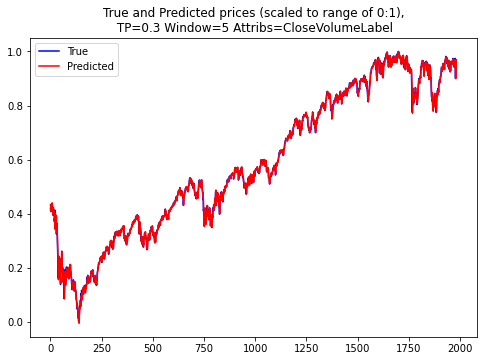

(1389,) (1389,)
Score 0.9964002879769619 1384 1389
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.3 5 Acc  0.9992800575953924 Acc PCA components  6 0.9964002879769619
Score 1.0 1385 1385
(1385,) (1385,)
Score 0.9949458483754513 1378 1385
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.3 10 Acc  1.0 Acc PCA components  11 0.9949458483754513
Score 0.9985454545454545 1373 1375
(1375,) (1375,)
Score 0.9949090909090909 1368 1375
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.3 25 Acc  0.9985454545454545 Acc PCA components  25 0.9949090909090909
Score 0.9985412107950401 1369 1371
(1371,) (1371,)
Score 0.9956236323851203 1365 1371
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.3 30 Acc  0.9985412107950401 Acc PCA components  30 0.9956236323851203
Score 0.998533724340176 1362 1364
(1364,) (1364,)
Score 0.998533724340176 1362 1364
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.3 40 Acc  0.998533724340176 Acc PCA components  39 0.9985337

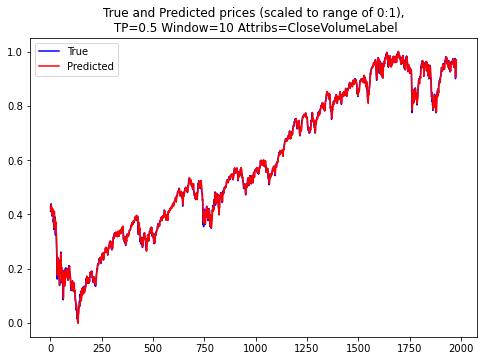

(989,) (989,)
Score 0.9969666329625885 986 989
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.5 10 Acc  1.0 Acc PCA components  11 0.9969666329625885
Score 1.0 982 982
(982,) (982,)
Score 0.994908350305499 977 982
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.5 25 Acc  1.0 Acc PCA components  25 0.994908350305499
Score 1.0 979 979
(979,) (979,)
Score 0.9959141981613892 975 979
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.5 30 Acc  1.0 Acc PCA components  30 0.9959141981613892
Score 1.0 974 974
(974,) (974,)
Score 0.9989733059548255 973 974
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.5 40 Acc  1.0 Acc PCA components  40 0.9989733059548255
Score 0.9979360165118679 967 969
(969,) (969,)
Score 1.0 969 969
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.5 50 Acc  0.9979360165118679 Acc PCA components  49 1.0
Score 1.0 967 967
(967,) (967,)
Score 1.0 967 967
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.5 55 Acc  1

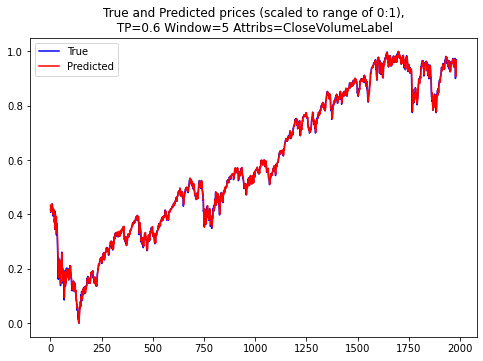

(794,) (794,)
Score 0.9974811083123426 792 794
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.6 5 Acc  1.0 Acc PCA components  6 0.9974811083123426
Score 1.0 792 792
(792,) (792,)
Score 0.9974747474747475 790 792
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.6 10 Acc  1.0 Acc PCA components  11 0.9974747474747475
Score 1.0 786 786
(786,) (786,)
Score 0.9961832061068703 783 786
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.6 25 Acc  1.0 Acc PCA components  26 0.9961832061068703
Score 1.0 784 784
(784,) (784,)
Score 0.9974489795918368 782 784
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.6 30 Acc  1.0 Acc PCA components  30 0.9974489795918368
Score 1.0 780 780
(780,) (780,)
Score 0.9987179487179487 779 780
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.6 40 Acc  1.0 Acc PCA components  40 0.9987179487179487
Score 0.9987113402061856 775 776
(776,) (776,)
Score 1.0 776 776
Completed  LinearRegression ['Close', 'Volume', 'Label'

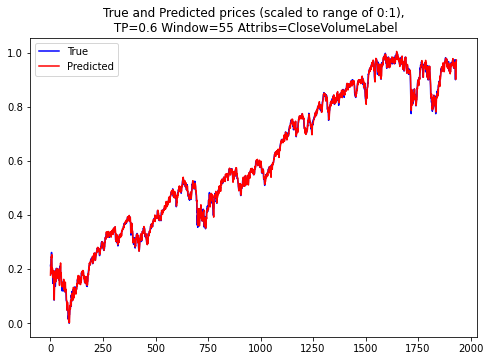

(774,) (774,)
Score 1.0 774 774
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.6 55 Acc  1.0 Acc PCA components  54 1.0
Score 0.9987046632124352 771 772
(772,) (772,)
Score 0.9987046632124352 771 772
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.6 60 Acc  0.9987046632124352 Acc PCA components  59 0.9987046632124352
Score 0.9974025974025974 768 770
(770,) (770,)
Score 0.9987012987012988 769 770
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.6 63 Acc  0.9974025974025974 Acc PCA components  61 0.9987012987012988
Score 0.9987012987012988 769 770
(770,) (770,)
Score 1.0 770 770
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.6 65 Acc  0.9987012987012988 Acc PCA components  63 1.0
Score 0.9986910994764397 763 764
(764,) (764,)
Score 1.0 764 764
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.6 80 Acc  0.9986910994764397 Acc PCA components  77 1.0
Score 0.9960526315789474 757 760
(760,) (760,)
Score 0.9986842105263158 759 760
Complete

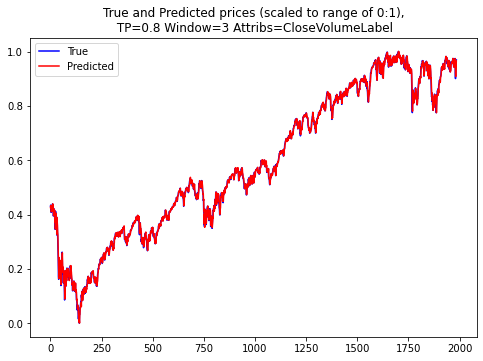

(397,) (397,)
Score 0.9974811083123426 396 397
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.8 3 Acc  1.0 Acc PCA components  4 0.9974811083123426
Score 1.0 397 397
(397,) (397,)
Score 0.9974811083123426 396 397
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.8 5 Acc  1.0 Acc PCA components  6 0.9974811083123426
Score 1.0 396 396
(396,) (396,)
Score 1.0 396 396
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.8 10 Acc  1.0 Acc PCA components  11 1.0
Score 1.0 393 393


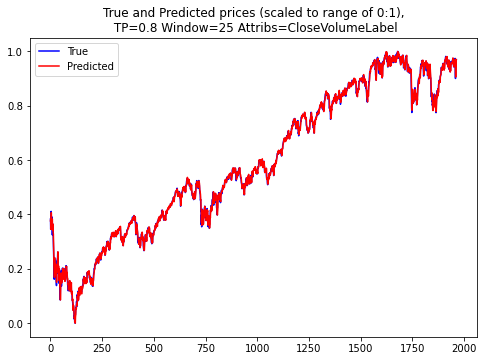

(393,) (393,)
Score 0.9974554707379135 392 393
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.8 25 Acc  1.0 Acc PCA components  26 0.9974554707379135
Score 1.0 392 392


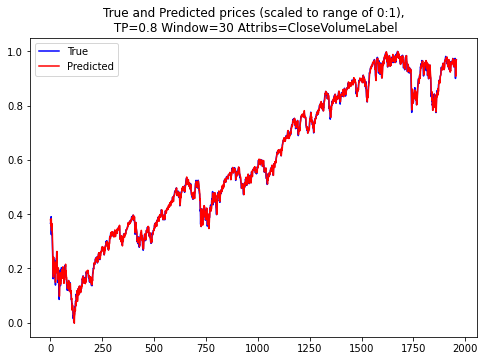

(392,) (392,)
Score 0.9974489795918368 391 392
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.8 30 Acc  1.0 Acc PCA components  30 0.9974489795918368
Score 1.0 390 390


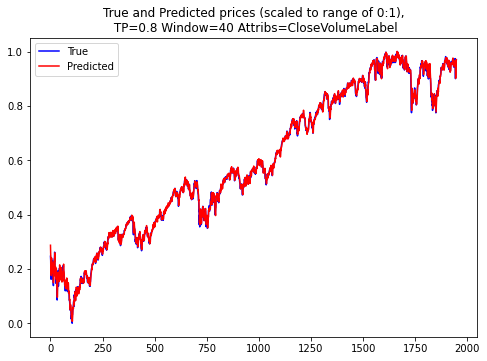

(390,) (390,)
Score 0.9948717948717949 388 390
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.8 40 Acc  1.0 Acc PCA components  40 0.9948717948717949
Score 1.0 388 388


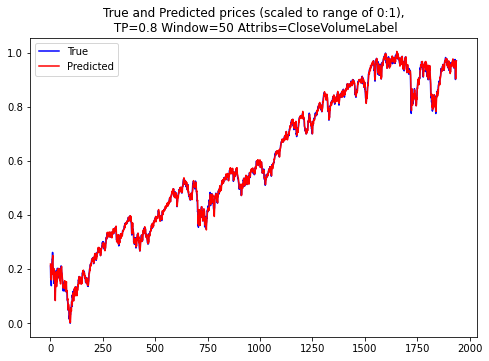

(388,) (388,)
Score 1.0 388 388
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.8 50 Acc  1.0 Acc PCA components  49 1.0
Score 1.0 387 387


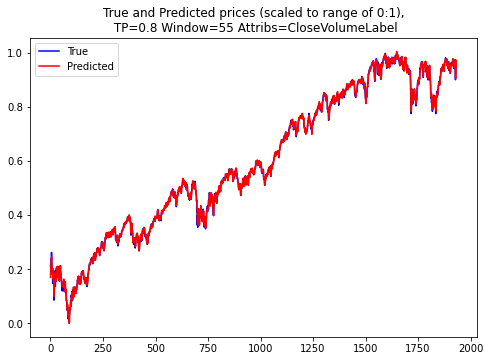

(387,) (387,)
Score 1.0 387 387
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.8 55 Acc  1.0 Acc PCA components  54 1.0
Score 1.0 386 386


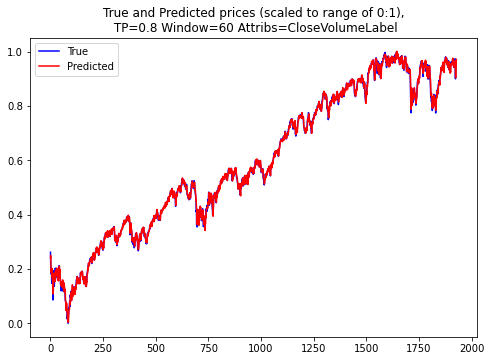

(386,) (386,)
Score 1.0 386 386
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.8 60 Acc  1.0 Acc PCA components  59 1.0
Score 1.0 385 385


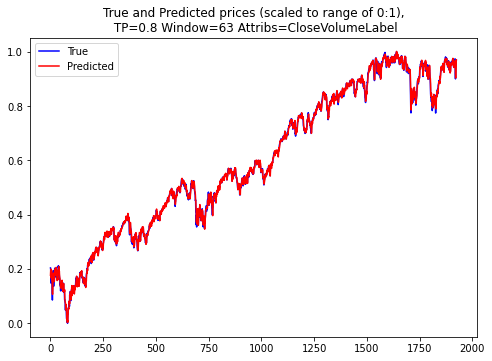

(385,) (385,)
Score 1.0 385 385
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.8 63 Acc  1.0 Acc PCA components  62 1.0
Score 1.0 385 385


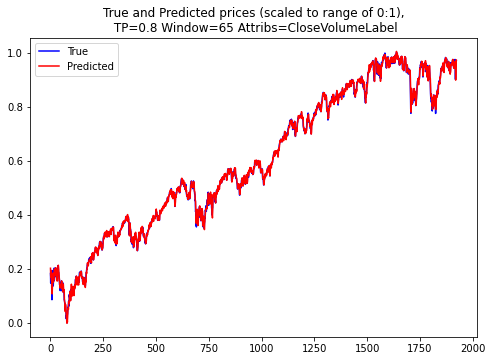

(385,) (385,)
Score 1.0 385 385
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.8 65 Acc  1.0 Acc PCA components  63 1.0
Score 1.0 382 382


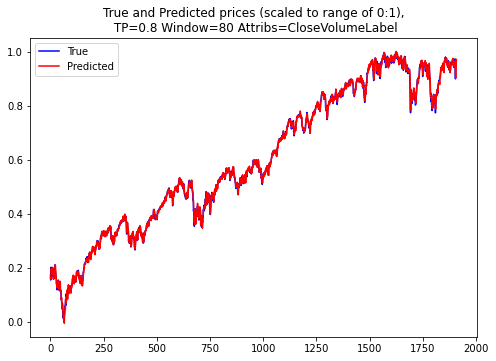

(382,) (382,)
Score 1.0 382 382
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.8 80 Acc  1.0 Acc PCA components  77 1.0
Score 1.0 380 380


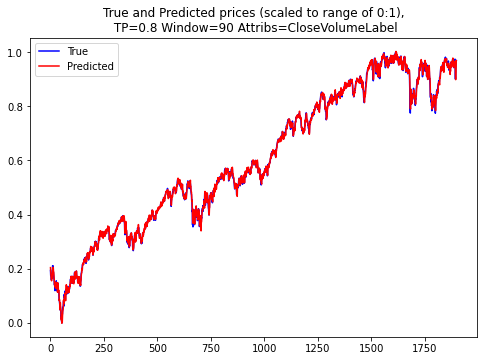

(380,) (380,)
Score 1.0 380 380
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.8 90 Acc  1.0 Acc PCA components  87 1.0
Score 1.0 374 374


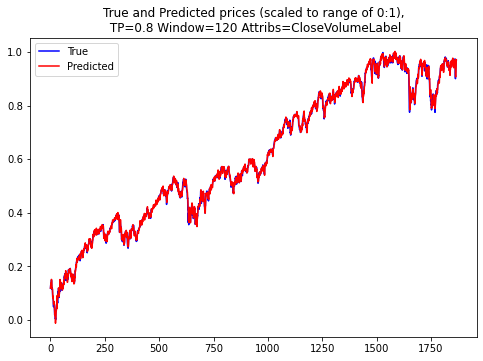

(374,) (374,)
Score 1.0 374 374
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.8 120 Acc  1.0 Acc PCA components  115 1.0
Score 0.9985611510791367 1388 1390
(1390,) (1390,)
Score 0.9971223021582734 1386 1390
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.3 3 Acc  0.9985611510791367 Acc PCA components  4 0.9971223021582734
Score 0.9985601151907847 1387 1389
(1389,) (1389,)
Score 0.9978401727861771 1386 1389
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.3 5 Acc  0.9985601151907847 Acc PCA components  6 0.9978401727861771
Score 1.0 1385 1385
(1385,) (1385,)
Score 0.9992779783393502 1384 1385
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.3 10 Acc  1.0 Acc PCA components  11 0.9992779783393502
Score 0.9992727272727273 1374 1375
(1375,) (1375,)
Score 1.0 1375 1375
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.3 25 Acc  0.9992727272727273 Acc PCA components  24 1.0
Score 

(764,) (764,)
Score 1.0 764 764
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.6 80 Acc  0.9986910994764397 Acc PCA components  74 1.0
Score 0.9947368421052631 756 760
(760,) (760,)
Score 0.9986842105263158 759 760
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.6 90 Acc  0.9947368421052631 Acc PCA components  83 0.9986842105263158
Score 1.0 748 748
(748,) (748,)
Score 1.0 748 748
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.6 120 Acc  1.0 Acc PCA components  109 1.0
Score 1.0 397 397


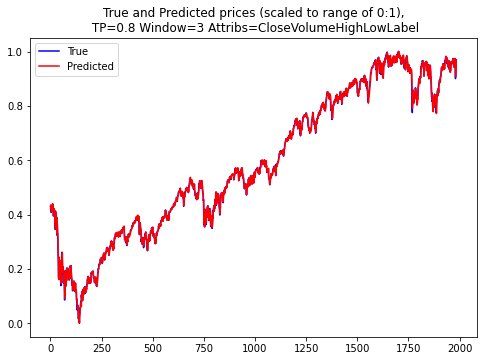

(397,) (397,)
Score 1.0 397 397
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.8 3 Acc  1.0 Acc PCA components  4 1.0
Score 1.0 397 397
(397,) (397,)
Score 0.9974811083123426 396 397
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.8 5 Acc  1.0 Acc PCA components  6 0.9974811083123426
Score 1.0 396 396
(396,) (396,)
Score 1.0 396 396
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.8 10 Acc  1.0 Acc PCA components  11 1.0
Score 0.9974554707379135 392 393
(393,) (393,)
Score 1.0 393 393
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.8 25 Acc  0.9974554707379135 Acc PCA components  25 1.0
Score 1.0 392 392
(392,) (392,)
Score 1.0 392 392
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.8 30 Acc  1.0 Acc PCA components  29 1.0
Score 1.0 390 390
(390,) (390,)
Score 1.0 390 390
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.8 40 Acc  1.0

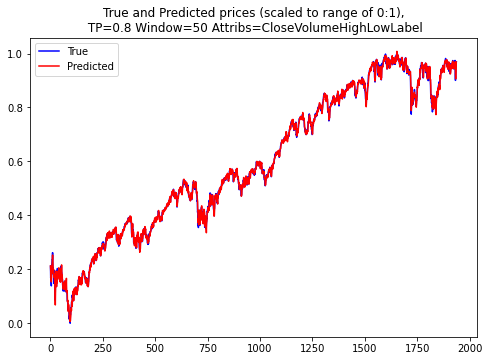

(388,) (388,)
Score 1.0 388 388
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.8 50 Acc  1.0 Acc PCA components  48 1.0
Score 1.0 387 387
(387,) (387,)
Score 1.0 387 387
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.8 55 Acc  1.0 Acc PCA components  52 1.0
Score 1.0 386 386
(386,) (386,)
Score 1.0 386 386
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.8 60 Acc  1.0 Acc PCA components  57 1.0
Score 1.0 385 385
(385,) (385,)
Score 1.0 385 385
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.8 63 Acc  1.0 Acc PCA components  59 1.0
Score 1.0 385 385
(385,) (385,)
Score 1.0 385 385
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.8 65 Acc  1.0 Acc PCA components  61 1.0
Score 1.0 382 382


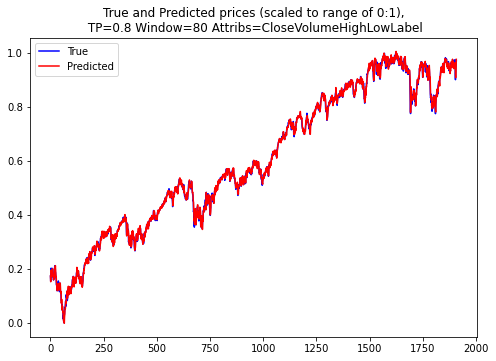

(382,) (382,)
Score 1.0 382 382
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.8 80 Acc  1.0 Acc PCA components  74 1.0
Score 1.0 380 380
(380,) (380,)
Score 1.0 380 380
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.8 90 Acc  1.0 Acc PCA components  83 1.0
Score 1.0 374 374
(374,) (374,)
Score 1.0 374 374
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.8 120 Acc  1.0 Acc PCA components  110 1.0
Score 0.9942446043165467 1382 1390
(1390,) (1390,)
Score 0.9964028776978417 1385 1390
Completed  LinearRegression ['Close', 'Volume'] 0.3 3 Acc  0.9942446043165467 Acc PCA components  2 0.9964028776978417
Score 0.9949604031677466 1382 1389
(1389,) (1389,)
Score 0.9971202303815695 1385 1389
Completed  LinearRegression ['Close', 'Volume'] 0.3 5 Acc  0.9949604031677466 Acc PCA components  2 0.9971202303815695
Score 0.9949458483754513 1378 1385
(1385,) (1385,)
Score 0.9935018050541516 1376 1385
Completed  LinearRegressi

(748,) (748,)
Score 0.9946524064171123 744 748
Completed  LinearRegression ['Close', 'Volume'] 0.6 120 Acc  0.9973262032085561 Acc PCA components  26 0.9946524064171123
Score 0.9924433249370277 394 397
(397,) (397,)
Score 0.9974811083123426 396 397
Completed  LinearRegression ['Close', 'Volume'] 0.8 3 Acc  0.9924433249370277 Acc PCA components  2 0.9974811083123426
Score 0.9924433249370277 394 397
(397,) (397,)
Score 0.9974811083123426 396 397
Completed  LinearRegression ['Close', 'Volume'] 0.8 5 Acc  0.9924433249370277 Acc PCA components  3 0.9974811083123426
Score 0.9949494949494949 394 396
(396,) (396,)
Score 0.9924242424242424 393 396
Completed  LinearRegression ['Close', 'Volume'] 0.8 10 Acc  0.9949494949494949 Acc PCA components  4 0.9924242424242424
Score 0.9923664122137404 390 393
(393,) (393,)
Score 0.9847328244274809 387 393
Completed  LinearRegression ['Close', 'Volume'] 0.8 25 Acc  0.9923664122137404 Acc PCA components  7 0.9847328244274809
Score 1.0 392 392


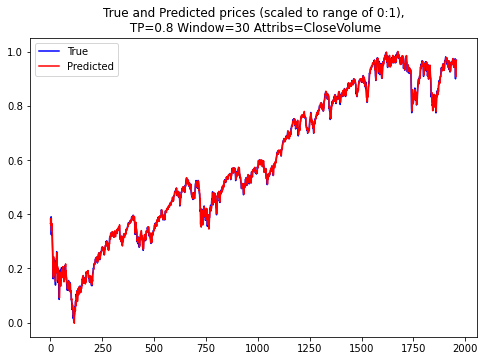

(392,) (392,)
Score 0.9744897959183674 382 392
Completed  LinearRegression ['Close', 'Volume'] 0.8 30 Acc  1.0 Acc PCA components  8 0.9744897959183674
Score 0.9923076923076923 387 390
(390,) (390,)
Score 0.9846153846153847 384 390
Completed  LinearRegression ['Close', 'Volume'] 0.8 40 Acc  0.9923076923076923 Acc PCA components  11 0.9846153846153847
Score 0.9948453608247423 386 388
(388,) (388,)
Score 0.9896907216494846 384 388
Completed  LinearRegression ['Close', 'Volume'] 0.8 50 Acc  0.9948453608247423 Acc PCA components  13 0.9896907216494846
Score 0.9922480620155039 384 387
(387,) (387,)
Score 0.9974160206718347 386 387
Completed  LinearRegression ['Close', 'Volume'] 0.8 55 Acc  0.9922480620155039 Acc PCA components  14 0.9974160206718347
Score 0.9948186528497409 384 386
(386,) (386,)
Score 0.9922279792746114 383 386
Completed  LinearRegression ['Close', 'Volume'] 0.8 60 Acc  0.9948186528497409 Acc PCA components  15 0.9922279792746114
Score 0.9896103896103896 381 385
(385,) (385

In [78]:
run_predictions_regression(df, attribsSet = [['Close', 'Volume', 'Label'],['Close', 'Volume', 'High', 'Low', 'Label'],['Close', 'Volume']],
                               train_percentages=[0.3,0.5,0.6,0.8],
                               window_sizes = [3,5,10,25,30,40,50,55,60,63,65,80,90,120],
                          csvPrefix='results_regression_tplus1_plt')

In [17]:
run_predictions_regression(df,
                          csvPrefix='results_regression_tplus1_')

Score 0.7341913822048125 1312 1787
(1787,) (1787,)
Score 0.6799104644655848 1215 1787
Completed  LinearRegression ['Close'] 0.1 3 Acc  0.7341913822048125 Acc PCA components  1 0.6799104644655848
Score 0.7204481792717087 1286 1785
(1785,) (1785,)
Score 0.5434173669467787 970 1785
Completed  LinearRegression ['Close'] 0.1 5 Acc  0.7204481792717087 Acc PCA components  1 0.5434173669467787
Score 0.7069062324536777 1259 1781
(1781,) (1781,)
Score 0.4862436833239753 866 1781
Completed  LinearRegression ['Close'] 0.1 10 Acc  0.7069062324536777 Acc PCA components  1 0.4862436833239753
Score 0.6998873873873874 1243 1776
(1776,) (1776,)
Score 0.4774774774774775 848 1776
Completed  LinearRegression ['Close'] 0.1 15 Acc  0.6998873873873874 Acc PCA components  1 0.4774774774774775
Score 0.713882618510158 1265 1772
(1772,) (1772,)
Score 0.4904063205417607 869 1772
Completed  LinearRegression ['Close'] 0.1 20 Acc  0.713882618510158 Acc PCA components  1 0.4904063205417607
Score 0.6893039049235993 121

(1390,) (1390,)
Score 0.685611510791367 953 1390
Completed  LinearRegression ['Close'] 0.3 3 Acc  0.7453237410071942 Acc PCA components  1 0.685611510791367
Score 0.7516198704103672 1044 1389
(1389,) (1389,)
Score 0.5521958243340532 767 1389
Completed  LinearRegression ['Close'] 0.3 5 Acc  0.7516198704103672 Acc PCA components  1 0.5521958243340532
Score 0.7350180505415163 1018 1385
(1385,) (1385,)
Score 0.49386281588447656 684 1385
Completed  LinearRegression ['Close'] 0.3 10 Acc  0.7350180505415163 Acc PCA components  1 0.49386281588447656
Score 0.723589001447178 1000 1382
(1382,) (1382,)
Score 0.48552821997105644 671 1382
Completed  LinearRegression ['Close'] 0.3 15 Acc  0.723589001447178 Acc PCA components  1 0.48552821997105644
Score 0.7329462989840348 1010 1378
(1378,) (1378,)
Score 0.4862119013062409 670 1378
Completed  LinearRegression ['Close'] 0.3 20 Acc  0.7329462989840348 Acc PCA components  1 0.4862119013062409
Score 0.728 1001 1375
(1375,) (1375,)
Score 0.4916363636363636

Score 0.44559585492227977 344 772
Completed  LinearRegression ['Close'] 0.6 60 Acc  0.7331606217616581 Acc PCA components  1 0.44559585492227977
Score 0.7233766233766233 557 770
(770,) (770,)
Score 0.45324675324675323 349 770
Completed  LinearRegression ['Close'] 0.6 63 Acc  0.7233766233766233 Acc PCA components  1 0.45324675324675323
Score 0.7025974025974026 541 770
(770,) (770,)
Score 0.4818181818181818 371 770
Completed  LinearRegression ['Close'] 0.6 65 Acc  0.7025974025974026 Acc PCA components  1 0.4818181818181818
Score 0.7122395833333334 547 768
(768,) (768,)
Score 0.484375 372 768
Completed  LinearRegression ['Close'] 0.6 70 Acc  0.7122395833333334 Acc PCA components  1 0.484375
Score 0.7133507853403142 545 764
(764,) (764,)
Score 0.4856020942408377 371 764
Completed  LinearRegression ['Close'] 0.6 80 Acc  0.7133507853403142 Acc PCA components  1 0.4856020942408377
Score 0.7289473684210527 554 760
(760,) (760,)
Score 0.5039473684210526 383 760
Completed  LinearRegression ['Clo

Score 0.9982352941176471 1697 1700
Completed  LinearRegression ['Label'] 0.1 100 Acc  0.9811764705882353 Acc PCA components  78 0.9982352941176471
Score 0.9367238320520402 1584 1691
(1691,) (1691,)
Score 0.9976345357776464 1687 1691
Completed  LinearRegression ['Label'] 0.1 110 Acc  0.9367238320520402 Acc PCA components  83 0.9976345357776464
Score 0.8816884661117717 1483 1682
(1682,) (1682,)
Score 0.9916765755053508 1668 1682
Completed  LinearRegression ['Label'] 0.1 120 Acc  0.8816884661117717 Acc PCA components  88 0.9916765755053508
Score 0.8876270173341303 1485 1673
(1673,) (1673,)
Score 0.9874476987447699 1652 1673
Completed  LinearRegression ['Label'] 0.1 130 Acc  0.8876270173341303 Acc PCA components  92 0.9874476987447699
Score 0.7806646525679758 1292 1655
(1655,) (1655,)
Score 0.9848942598187311 1630 1655
Completed  LinearRegression ['Label'] 0.1 150 Acc  0.7806646525679758 Acc PCA components  100 0.9848942598187311
Score 0.9993702770780857 1587 1588
(1588,) (1588,)
Score 0.9

Score 0.998991935483871 991 992
(992,) (992,)
Score 0.998991935483871 991 992
Completed  LinearRegression ['Label'] 0.5 5 Acc  0.998991935483871 Acc PCA components  5 0.998991935483871
Score 1.0 989 989
(989,) (989,)
Score 1.0 989 989
Completed  LinearRegression ['Label'] 0.5 10 Acc  1.0 Acc PCA components  10 1.0
Score 0.9989868287740629 986 987
(987,) (987,)
Score 0.9989868287740629 986 987
Completed  LinearRegression ['Label'] 0.5 15 Acc  0.9989868287740629 Acc PCA components  15 0.9989868287740629
Score 0.9989837398373984 983 984
(984,) (984,)
Score 0.9989837398373984 983 984
Completed  LinearRegression ['Label'] 0.5 20 Acc  0.9989837398373984 Acc PCA components  19 0.9989837398373984
Score 1.0 982 982
(982,) (982,)
Score 1.0 982 982
Completed  LinearRegression ['Label'] 0.5 25 Acc  1.0 Acc PCA components  24 1.0
Score 1.0 979 979
(979,) (979,)
Score 1.0 979 979
Completed  LinearRegression ['Label'] 0.5 30 Acc  1.0 Acc PCA components  28 1.0
Score 1.0 974 974
(974,) (974,)
Score 1.

(380,) (380,)
Score 1.0 380 380
Completed  LinearRegression ['Label'] 0.8 90 Acc  1.0 Acc PCA components  83 1.0
Score 0.9973544973544973 377 378
(378,) (378,)
Score 0.9973544973544973 377 378
Completed  LinearRegression ['Label'] 0.8 100 Acc  0.9973544973544973 Acc PCA components  92 0.9973544973544973
Score 1.0 376 376
(376,) (376,)
Score 1.0 376 376
Completed  LinearRegression ['Label'] 0.8 110 Acc  1.0 Acc PCA components  101 1.0
Score 1.0 374 374
(374,) (374,)
Score 1.0 374 374
Completed  LinearRegression ['Label'] 0.8 120 Acc  1.0 Acc PCA components  110 1.0
Score 1.0 372 372
(372,) (372,)
Score 1.0 372 372
Completed  LinearRegression ['Label'] 0.8 130 Acc  1.0 Acc PCA components  119 1.0
Score 1.0 368 368
(368,) (368,)
Score 1.0 368 368
Completed  LinearRegression ['Label'] 0.8 150 Acc  1.0 Acc PCA components  137 1.0
Score 0.9938444320089536 1776 1787
(1787,) (1787,)
Score 0.996082820369334 1780 1787
Completed  LinearRegression ['Close', 'Volume'] 0.1 3 Acc  0.9938444320089536 

Score 0.9893546240851631 1487 1503
(1503,) (1503,)
Score 0.9913506320691949 1490 1503
Completed  LinearRegression ['Close', 'Volume'] 0.2 110 Acc  0.9893546240851631 Acc PCA components  19 0.9913506320691949
Score 0.9899665551839465 1480 1495
(1495,) (1495,)
Score 0.9926421404682274 1484 1495
Completed  LinearRegression ['Close', 'Volume'] 0.2 120 Acc  0.9899665551839465 Acc PCA components  21 0.9926421404682274
Score 0.9872225958305313 1468 1487
(1487,) (1487,)
Score 0.9858776059179556 1466 1487
Completed  LinearRegression ['Close', 'Volume'] 0.2 130 Acc  0.9872225958305313 Acc PCA components  22 0.9858776059179556
Score 0.9850441876274643 1449 1471
(1471,) (1471,)
Score 0.982324949014276 1445 1471
Completed  LinearRegression ['Close', 'Volume'] 0.2 150 Acc  0.9850441876274643 Acc PCA components  25 0.982324949014276
Score 0.9942446043165467 1382 1390
(1390,) (1390,)
Score 0.9964028776978417 1385 1390
Completed  LinearRegression ['Close', 'Volume'] 0.3 3 Acc  0.9942446043165467 Acc PC

Score 0.9925452609158679 932 939
Completed  LinearRegression ['Close', 'Volume'] 0.5 110 Acc  0.9936102236421726 Acc PCA components  23 0.9925452609158679
Score 0.9967880085653105 931 934
(934,) (934,)
Score 0.9935760171306209 928 934
Completed  LinearRegression ['Close', 'Volume'] 0.5 120 Acc  0.9967880085653105 Acc PCA components  25 0.9935760171306209
Score 0.9881593110871906 918 929
(929,) (929,)
Score 0.9881593110871906 918 929
Completed  LinearRegression ['Close', 'Volume'] 0.5 130 Acc  0.9881593110871906 Acc PCA components  27 0.9881593110871906
Score 0.9880304678998912 908 919
(919,) (919,)
Score 0.9815016322089227 902 919
Completed  LinearRegression ['Close', 'Volume'] 0.5 150 Acc  0.9880304678998912 Acc PCA components  30 0.9815016322089227
Score 0.9937027707808564 789 794
(794,) (794,)
Score 0.9974811083123426 792 794
Completed  LinearRegression ['Close', 'Volume'] 0.6 3 Acc  0.9937027707808564 Acc PCA components  2 0.9974811083123426
Score 0.9937027707808564 789 794
(794,) 

Score 0.9920212765957447 373 376
(376,) (376,)
Score 0.9946808510638298 374 376
Completed  LinearRegression ['Close', 'Volume'] 0.8 110 Acc  0.9920212765957447 Acc PCA components  25 0.9946808510638298
Score 0.9973262032085561 373 374
(374,) (374,)
Score 0.9919786096256684 371 374
Completed  LinearRegression ['Close', 'Volume'] 0.8 120 Acc  0.9973262032085561 Acc PCA components  27 0.9919786096256684
Score 0.9919354838709677 369 372
(372,) (372,)
Score 0.9838709677419355 366 372
Completed  LinearRegression ['Close', 'Volume'] 0.8 130 Acc  0.9919354838709677 Acc PCA components  29 0.9838709677419355
Score 0.9918478260869565 365 368
(368,) (368,)
Score 0.9836956521739131 362 368
Completed  LinearRegression ['Close', 'Volume'] 0.8 150 Acc  0.9918478260869565 Acc PCA components  32 0.9836956521739131
Score 0.9983212087297146 1784 1787
(1787,) (1787,)
Score 0.9938444320089536 1776 1787
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.1 3 Acc  0.9983212087297146 Acc PCA components 

(1527,) (1527,)
Score 0.9993451211525868 1526 1527
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.2 80 Acc  0.9967256057629339 Acc PCA components  73 0.9993451211525868
Score 0.9921000658327848 1507 1519
(1519,) (1519,)
Score 0.9953917050691244 1512 1519
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.2 90 Acc  0.9921000658327848 Acc PCA components  82 0.9953917050691244
Score 0.9933818663136995 1501 1511
(1511,) (1511,)
Score 0.99867637326274 1509 1511
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.2 100 Acc  0.9933818663136995 Acc PCA components  89 0.99867637326274
Score 0.9880239520958084 1485 1503
(1503,) (1503,)
Score 0.9973386560212908 1499 1503
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.2 110 Acc  0.9880239520958084 Acc PCA components  97 0.9973386560212908
Score 0.9785953177257525 1463 1495
(1495,) (1495,)
Score 0.9986622073578595 1493 1495
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.2 120 Acc  0.978595317725752

(962,) (962,)
Score 1.0 962 962
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.5 65 Acc  0.998960498960499 Acc PCA components  63 1.0
Score 0.9989572471324296 958 959
(959,) (959,)
Score 1.0 959 959
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.5 70 Acc  0.9989572471324296 Acc PCA components  68 1.0
Score 0.9989517819706499 953 954
(954,) (954,)
Score 1.0 954 954
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.5 80 Acc  0.9989517819706499 Acc PCA components  77 1.0
Score 0.9978925184404637 947 949
(949,) (949,)
Score 0.9989462592202318 948 949
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.5 90 Acc  0.9978925184404637 Acc PCA components  86 0.9989462592202318
Score 0.9978813559322034 942 944
(944,) (944,)
Score 0.9989406779661016 943 944
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.5 100 Acc  0.9978813559322034 Acc PCA components  95 0.9989406779661016
Score 0.9989350372736954 938 939
(939,) (939,)
Score 0.9989350372736954 9

(376,) (376,)
Score 1.0 376 376
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.8 110 Acc  1.0 Acc PCA components  105 1.0
Score 1.0 374 374
(374,) (374,)
Score 1.0 374 374
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.8 120 Acc  1.0 Acc PCA components  115 1.0
Score 1.0 372 372
(372,) (372,)
Score 1.0 372 372
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.8 130 Acc  1.0 Acc PCA components  124 1.0
Score 0.9972826086956522 367 368
(368,) (368,)
Score 1.0 368 368
Completed  LinearRegression ['Close', 'Volume', 'Label'] 0.8 150 Acc  0.9972826086956522 Acc PCA components  142 1.0
Score 0.9988808058198098 1785 1787
(1787,) (1787,)
Score 0.9966424174594292 1781 1787
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.1 3 Acc  0.9988808058198098 Acc PCA components  4 0.9966424174594292
Score 0.9994397759103641 1784 1785
(1785,) (1785,)
Score 0.9966386554621849 1779 1785
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'L

Score 0.9856677524429968 1513 1535
(1535,) (1535,)
Score 0.9986970684039088 1533 1535
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.2 70 Acc  0.9856677524429968 Acc PCA components  61 0.9986970684039088
Score 0.9744597249508841 1488 1527
(1527,) (1527,)
Score 1.0 1527 1527
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.2 80 Acc  0.9744597249508841 Acc PCA components  69 1.0
Score 0.9835418038183015 1494 1519
(1519,) (1519,)
Score 0.9980250164581962 1516 1519
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.2 90 Acc  0.9835418038183015 Acc PCA components  77 0.9980250164581962
Score 0.9894109861019192 1495 1511
(1511,) (1511,)
Score 0.99867637326274 1509 1511
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.2 100 Acc  0.9894109861019192 Acc PCA components  84 0.99867637326274
Score 0.9946773120425815 1495 1503
(1503,) (1503,)
Score 0.998003992015968 1500 1503
Completed  LinearRegress

(964,) (964,)
Score 0.9989626556016598 963 964
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.5 60 Acc  0.9989626556016598 Acc PCA components  56 0.9989626556016598
Score 0.9968847352024922 960 963
(963,) (963,)
Score 0.9989615784008308 962 963
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.5 63 Acc  0.9968847352024922 Acc PCA components  59 0.9989615784008308
Score 0.997920997920998 960 962
(962,) (962,)
Score 1.0 962 962
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.5 65 Acc  0.997920997920998 Acc PCA components  60 1.0
Score 0.9989572471324296 958 959
(959,) (959,)
Score 1.0 959 959
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.5 70 Acc  0.9989572471324296 Acc PCA components  65 1.0
Score 0.9979035639412998 952 954
(954,) (954,)
Score 1.0 954 954
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.5 80 Acc  0.9979035639412998 Acc PCA components  74 1.0


Score 1.0 385 385
(385,) (385,)
Score 1.0 385 385
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.8 63 Acc  1.0 Acc PCA components  59 1.0
Score 1.0 385 385
(385,) (385,)
Score 1.0 385 385
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.8 65 Acc  1.0 Acc PCA components  61 1.0
Score 0.9973958333333334 383 384
(384,) (384,)
Score 1.0 384 384
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.8 70 Acc  0.9973958333333334 Acc PCA components  65 1.0
Score 1.0 382 382
(382,) (382,)
Score 1.0 382 382
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.8 80 Acc  1.0 Acc PCA components  74 1.0
Score 1.0 380 380
(380,) (380,)
Score 1.0 380 380
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.8 90 Acc  1.0 Acc PCA components  83 1.0
Score 1.0 378 378
(378,) (378,)
Score 0.9973544973544973 377 378
Completed  LinearRegression ['Close', 'Volume', 'High', 'Low', 'Label'] 0.8 100 

In [83]:
def create_models(window,attribsSet,attribIndex,output_size=1):  
            result=[]
            ann_name='model_1_2hidden_relu_adam'
            #building the model
            model = Sequential()
            model.add(Dense(window, activation='relu', input_shape=(window*len(attribsSet[attribIndex]),)))
            model.add(Dense(int(window*3), activation='relu'))
            model.add(Dense(int(window*3), activation='relu'))                            
            model.add(Dense(output_size, activation='relu'))            
            model.compile(optimizer='adam', loss='mean_squared_error')
            result.append([ann_name,model])
            
#             ann_name='model_2_2hidden_tanh_adam'
#             #building the model
#             model = Sequential()
#             model.add(Dense(window, activation='tanh', input_shape=(window*len(attribsSet[attribIndex]),)))
#             model.add(Dense(int(window*3), activation='tanh'))
#             model.add(Dense(int(window*3), activation='tanh'))                            
#             model.add(Dense(output_size, activation='tanh'))            
#             model.compile(optimizer='adam', loss='mean_squared_error')
#             result.append([ann_name,model])
            
#             ann_name='model_3_2hidden_softmax_adam'
#             #building the model
#             model = Sequential()
#             model.add(Dense(window, activation='softmax', input_shape=(window*len(attribsSet[attribIndex]),)))
#             model.add(Dense(int(window*3), activation='softmax'))
#             model.add(Dense(int(window*3), activation='softmax'))                            
#             model.add(Dense(output_size, activation='softmax'))            
#             model.compile(optimizer='adam', loss='mean_squared_error')
#             result.append([ann_name,model])
            
#             ann_name='model_4_2hidden_softmax_sgd'
#             #building the model
#             model = Sequential()
#             model.add(Dense(window, activation='softmax', input_shape=(window*len(attribsSet[attribIndex]),)))
#             model.add(Dense(int(window*3), activation='softmax'))
#             model.add(Dense(int(window*3), activation='softmax'))                            
#             model.add(Dense(output_size, activation='softmax'))            
#             model.compile(optimizer='sgd', loss='mean_squared_error')
#             result.append([ann_name,model])
            
#             ann_name='model_5_2hidden_softmax_adagrad'
#             #building the model
#             model = Sequential()
#             model.add(Dense(window, activation='softmax', input_shape=(window*len(attribsSet[attribIndex]),)))
#             model.add(Dense(int(window*3), activation='softmax'))
#             model.add(Dense(int(window*3), activation='softmax'))                            
#             model.add(Dense(output_size, activation='softmax'))                        
#             model.compile(optimizer='adagrad', loss='mean_squared_error')
#             result.append([ann_name,model])
            
             
            
            ann_name='model_6_4hidden_relu_adam'
            #building the model
            model = Sequential()
            model.add(Dense(window, activation='relu', input_shape=(window*len(attribsSet[attribIndex]),)))
            model.add(Dense(int(window*3), activation='relu'))
            model.add(Dense(int(window*4), activation='relu'))                            
            model.add(Dense(int(window*4), activation='relu'))  
            model.add(Dense(int(window*3), activation='relu'))
            model.add(Dense(output_size, activation='relu'))            
            model.compile(optimizer='adam', loss='mean_squared_error')
            result.append([ann_name,model])
            
            
            
            ann_name='model_7_4hidden_tanh_relu_adam'
            #building the model
            model = Sequential()
            model.add(Dense(window, activation='tanh', input_shape=(window*len(attribsSet[attribIndex]),)))
            model.add(Dense(int(window*3), activation='relu'))
            model.add(Dense(int(window*3), activation='relu'))                            
            model.add(Dense(int(window*3), activation='tanh'))  
            model.add(Dense(int(window*3), activation='tanh'))
            model.add(Dense(output_size, activation='relu'))            
            model.compile(optimizer='adam', loss='mean_squared_error')
            result.append([ann_name,model])
            
#             ann_name='model_7.5_4hidden_tanh_relu_adagrad'
#             #building the model
#             model = Sequential()
#             model.add(Dense(window, activation='tanh', input_shape=(window*len(attribsSet[attribIndex]),)))
#             model.add(Dense(int(window*3), activation='relu'))
#             model.add(Dense(int(window*3), activation='relu'))                            
#             model.add(Dense(int(window*3), activation='tanh'))  
#             model.add(Dense(int(window*3), activation='tanh'))
#             model.add(Dense(output_size, activation='relu'))            
#             model.compile(optimizer='adagrad', loss='mean_squared_error')
#             result.append([ann_name,model])
            
            
            
            
#             ann_name='model_8_4hidden_tanh_softmax_adagrad'
#             #building the model
#             model = Sequential()
#             model.add(Dense(window, activation='tanh', input_shape=(window*len(attribsSet[attribIndex]),)))
#             model.add(Dense(int(window*2), activation='softmax'))
#             model.add(Dense(int(window*3), activation='softmax'))                            
#             model.add(Dense(int(window*3), activation='tanh'))  
#             model.add(Dense(int(window*2), activation='tanh'))
#             model.add(Dense(output_size, activation='softmax'))            
#             model.compile(optimizer='adagrad', loss='mean_squared_error')
#             result.append([ann_name,model])
            
            ann_name='model_9_5hidden_relu_adam'
            #building the model
            model = Sequential()
            model.add(Dense(window, activation='relu', input_shape=(window*len(attribsSet[attribIndex]),)))
            model.add(Dense(int(window*3), activation='relu'))
            model.add(Dense(int(window*4), activation='relu'))                            
            model.add(Dense(int(window*5), activation='relu'))                            
            model.add(Dense(int(window*4), activation='relu'))  
            model.add(Dense(int(window*3), activation='relu'))
            model.add(Dense(output_size, activation='relu'))            
            model.compile(optimizer='adam', loss='mean_squared_error')
            result.append([ann_name,model])
            
            ann_name='model_10_5hidden_tanh_relu_adam'
            #building the model
            model = Sequential()
            model.add(Dense(window, activation='tanh', input_shape=(window*len(attribsSet[attribIndex]),)))
            model.add(Dense(int(window*4), activation='relu'))
            model.add(Dense(int(window*5), activation='tanh'))                            
            model.add(Dense(int(window*6), activation='relu'))                            
            model.add(Dense(int(window*5), activation='tanh'))  
            model.add(Dense(int(window*4), activation='relu'))
            model.add(Dense(output_size, activation='relu'))            
            model.compile(optimizer='adam', loss='mean_squared_error')
            result.append([ann_name,model])
            
            return result

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

from keras.layers import LSTM

In [85]:
def run_predictions_ann(df,prediction_cols = [['Close']],label_col='Label',
                        attribsSet=[['Close','Volume','High','Low']],
                        epochsList=[200,300],
                        validation_sizes=[0.15,0.2,0.3,0.35],
                        batch_sizes=[30,40,50,60,70,80],
                        train_percentages=[0.3,0.5,0.7],
                        window_sizes = [5,10,15,20,30,50,60,65,80,90,100,120,150],                        
                        csvPrefix='results_ann'):
    resultsANN=[]            
    ts_acc_best=-2.0
    best=[]    
    output_size=1
    for attribIndex in range(0,len(attribsSet)):    
        for train_per in train_percentages:              
            for window in window_sizes:
                X,YCombo,Z = create_dataset_reg(df,attribsSet,attribIndex,
                            prediction_cols,pindex=0,label_col=label_col,window=window)
                min_max_scaler = MinMaxScaler(feature_range=(0,1))
                X = min_max_scaler.fit_transform(X) 
                YCombo = min_max_scaler.fit_transform(YCombo) 
                x_train,x_test,y_train,y_test = train_test_split(X, YCombo, test_size=(1-train_per), random_state=22)
                price_train = y_train[:,0]
                price_test  = y_test[:,0]
                                            
                start = time.time()
                print('Creating models for window size ',window)
                modelList = create_models(window,attribsSet,attribIndex,y_train.shape[1])
                print('Created models for window size ',window,' in ',(time.time()-start))
                for name, model in modelList:
                    for epoch in epochsList:
                        for validation_size in validation_sizes:
                            for batch_size in batch_sizes:
                                print('Running model ',name,' with epoch ',epoch,attribsSet[attribIndex],window,train_per,validation_size,batch_size)
                                start = time.time()
                                #training the model
                                #history = model.fit(x_train, y_train, epochs=50, batch_size = 2)
                                history = model.fit(x_train, y_train, validation_split=validation_size,
                                                    epochs=epoch, batch_size=batch_size, verbose=0,shuffle=False)
                                #print(model.summary())
                                y_test_pred=model.predict(x_test)
                                #print(y_test_pred[:,0],y_test[:,0],y_test_pred[:,1],y_test[:,1])
                                ts_acc = accuracy_of_direction(y_test_pred,x_test,price_test,attribsSet[attribIndex],0) 
                                mse = mean_squared_error(price_test, y_test_pred)

                                print(ts_acc)
                                print('Completed model ',name,' with epoch ',epoch,
                                       [attribsSet[attribIndex],train_per,window,name,epoch,ts_acc],
                                       'Time ',(time.time()-start)
                                      )

                                resultsANN.append([attribsSet[attribIndex],train_per,window,name,epoch,validation_size,batch_size,ts_acc,mse])
                                if(ts_acc_best <= ts_acc) :
                                         ts_acc_best = ts_acc
                                         best = [train_per,window,attribsSet[attribIndex],name,validation_size,batch_size]    
    save_results_to_csv(resultsANN,
                         ['Attributes','Train Per','Window size','ModelName','Epoch','ValidationSize','BatchSize','Accuracy','MSE']
                         ,csvPrefix)                      

    print('Best ',best,'Acc',ts_acc_best)  
    

In [ ]:
run_predictions_ann(df,epochsList=[100],
                        attribsSet = [['Close'],['Label'],['Close','Volume','Label'],['Close','Volume','High','Low','Label']],
                        train_percentages=[0.3,0.7],
                        window_sizes = [5,10,20,30,40,50,60],
                        validation_sizes=[0.15],
                        batch_sizes=[80,90],
                          csvPrefix='results_ann_tplus1_temp_')

Creating models for window size  5
Created models for window size  5  in  1.9547865390777588
Running model  model_1_2hidden_relu_adam  with epoch  100 ['Close'] 5 0.3 0.15 80
Score 0.4456443484521238 619 1389
0.4456443484521238
Completed model  model_1_2hidden_relu_adam  with epoch  100 [['Close'], 0.3, 5, 'model_1_2hidden_relu_adam', 100, 0.4456443484521238] Time  7.406620979309082
Running model  model_1_2hidden_relu_adam  with epoch  100 ['Close'] 5 0.3 0.15 90
Score 0.4456443484521238 619 1389
0.4456443484521238
Completed model  model_1_2hidden_relu_adam  with epoch  100 [['Close'], 0.3, 5, 'model_1_2hidden_relu_adam', 100, 0.4456443484521238] Time  2.5922060012817383
Running model  model_6_4hidden_relu_adam  with epoch  100 ['Close'] 5 0.3 0.15 80
Score 0.4456443484521238 619 1389
0.4456443484521238
Completed model  model_6_4hidden_relu_adam  with epoch  100 [['Close'], 0.3, 5, 'model_6_4hidden_relu_adam', 100, 0.4456443484521238] Time  3.2568399906158447
Running model  model_6_4hi

In [ ]:
dfTplus5=df.dropna(subset=['Label5'])

print('Performing T plus 5')
run_predictions_classifier(df,prediction_cols = [['Label5']],attribsSet =[['Close','Volume','High','Low']],
                           train_percentages=[0.6],
                           window_sizes = [60],
                          csvPrefix='results_classification_tplus5_')

run_predictions_regression(dfTplus5,prediction_cols = [['Close5']],label_col='Label5',
                              attribsSet = [['Close'],['Close','Volume'],['Close','Volume','High','Low']],                               
                               csvPrefix='results_regression_tplus5'                               
                              )

run_predictions_ann(df,prediction_cols = [['Close5']],label_col='Label5',epochsList=[200],
                        train_percentages=[0.5,0.7],
                        window_sizes = [60],
                          csvPrefix='results_ann_tplus5_')


In [ ]:
dfTplus20=df.dropna(subset=['Label20'])

print('Performing T plus 20')
run_predictions_classifier(df,prediction_cols = [['Label20']],attribsSet =[['Close','Volume','High','Low']],
                           train_percentages=[0.6],
                           window_sizes = [60],
                          csvPrefix='results_classification_tplus5_')

run_predictions_regression(dfTplus5,prediction_cols = [['Close20']],label_col='Label20',
                              attribsSet = [['Close'],['Close','Volume'],['Close','Volume','High','Low']],                               
                               csvPrefix='results_regression_tplus5'                               
                              )

run_predictions_ann(df,prediction_cols = [['Close20']],label_col='Label20',epochsList=[200],
                        train_percentages=[0.5,0.7],
                        window_sizes = [60],
                          csvPrefix='results_ann_tplus20_')

In [ ]:
def create_models_rnn_lstm(window,attribsSet,attribIndex,output_size=1):  
            result=[]
        
            ann_name='model_RNN_1_2hidden_relu_adam'            
            model = Sequential()
            #first RNN layer of model   return_sequences=True
            model.add(keras.layers.recurrent.SimpleRNN(units = Train_X_w2v.shape[1], input_dim=Train_X_w2v.shape[1], input_shape=(Train_X_w2v.shape[1],1), activation='relu', use_bias=True))
            model.add(keras.layers.Dense(units=10, activation='relu'))

model.add(keras.layers.Dense(units=1, activation='sigmoid'))
            result.append([ann_name,model])
        
            ann_name='model_LSTM_1_3LSTM'            
            model=Sequential()
            model.add(LSTM(window,return_sequences=True,input_shape=(100,1)))
            model.add(LSTM(window,return_sequences=True))
            model.add(LSTM(window))
            model.add(Dense(1))
            model.compile(loss='mean_squared_error',optimizer='adam')
            result.append([ann_name,model])
            
    
    